### Introduction
### Build a machine model to predict whether the freshwater is safe to drink or not.Based on the measures like pH, TDS, etc.

### Import necessary packages and libraries

In [1]:
pip install -U modin -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install klib -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import klib
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import anderson
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### import the dataset

#### The dataset contains almost 6 million records.Let's read the dataset using pandas library and see how long ita takes to read the dataset. 

In [4]:
%time data=pd.read_csv("/kaggle/input/intel-oneapi-predict-the-quality-of-freshwater/dataset.csv")

CPU times: user 34.5 s, sys: 3.33 s, total: 37.8 s
Wall time: 1min 5s


### Let's accelerate pandas using the intel distribution of modin and see the duration time.

In [5]:
import modin.pandas as pd

In [6]:
%time data=pd.read_csv("/kaggle/input/intel-oneapi-predict-the-quality-of-freshwater/dataset.csv")

2023-02-27 10:01:06,570	INFO worker.py:1538 -- Started a local Ray instance.
2023-02-27 10:01:08,012	WARNING __init__.py:183 -- DeprecationWarning: `ray.worker.global_worker` is a private attribute and access will be removed in a future Ray version.


CPU times: user 3.81 s, sys: 2.3 s, total: 6.11 s
Wall time: 25.9 s


#### The above information explain that the intel modin 80% faster than the pandas.

### Let's see the structure of train dataset

In [7]:
%time data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 5956842 entries, 0 to 5956841
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype  
---  ----------------------  ----------------  -----  
 0   Index                   5956842 non-null  int64
 1   pH                      5840788 non-null  float64
 2   Iron                    5917089 non-null  float64
 3   Nitrate                 5851117 non-null  float64
 4   Chloride                5781311 non-null  float64
 5   Lead                    5929933 non-null  float64
 6   Zinc                    5800716 non-null  float64
 7   Color                   5951103 non-null  object
 8   Turbidity               5907027 non-null  float64
 9   Fluoride                5767686 non-null  float64
 10  Copper                  5757440 non-null  float64
 11  Odor                    5777951 non-null  float64
 12  Sulfate                 5759424 non-null  float64
 13  Conductivity            5792981 non-null  float64
 14  

#### The dataset contains 5956842 rows and 24 columns.

### Let's see column wise missing value count.

In [8]:
data.isnull().sum()

Index                          0
pH                        116054
Iron                       39753
Nitrate                   105725
Chloride                  175531
Lead                       26909
Zinc                      156126
Color                       5739
Turbidity                  49815
Fluoride                  189156
Copper                    199402
Odor                      178891
Sulfate                   197418
Conductivity              163861
Chlorine                   57825
Manganese                 109583
Total Dissolved Solids      1670
Source                     88262
Water Temperature         168233
Air Temperature            29728
Month                      95668
Day                        99603
Time of Day               114519
Target                         0
dtype: int64

### Let's explore the column wise null values by bar chart.

<AxesSubplot:>

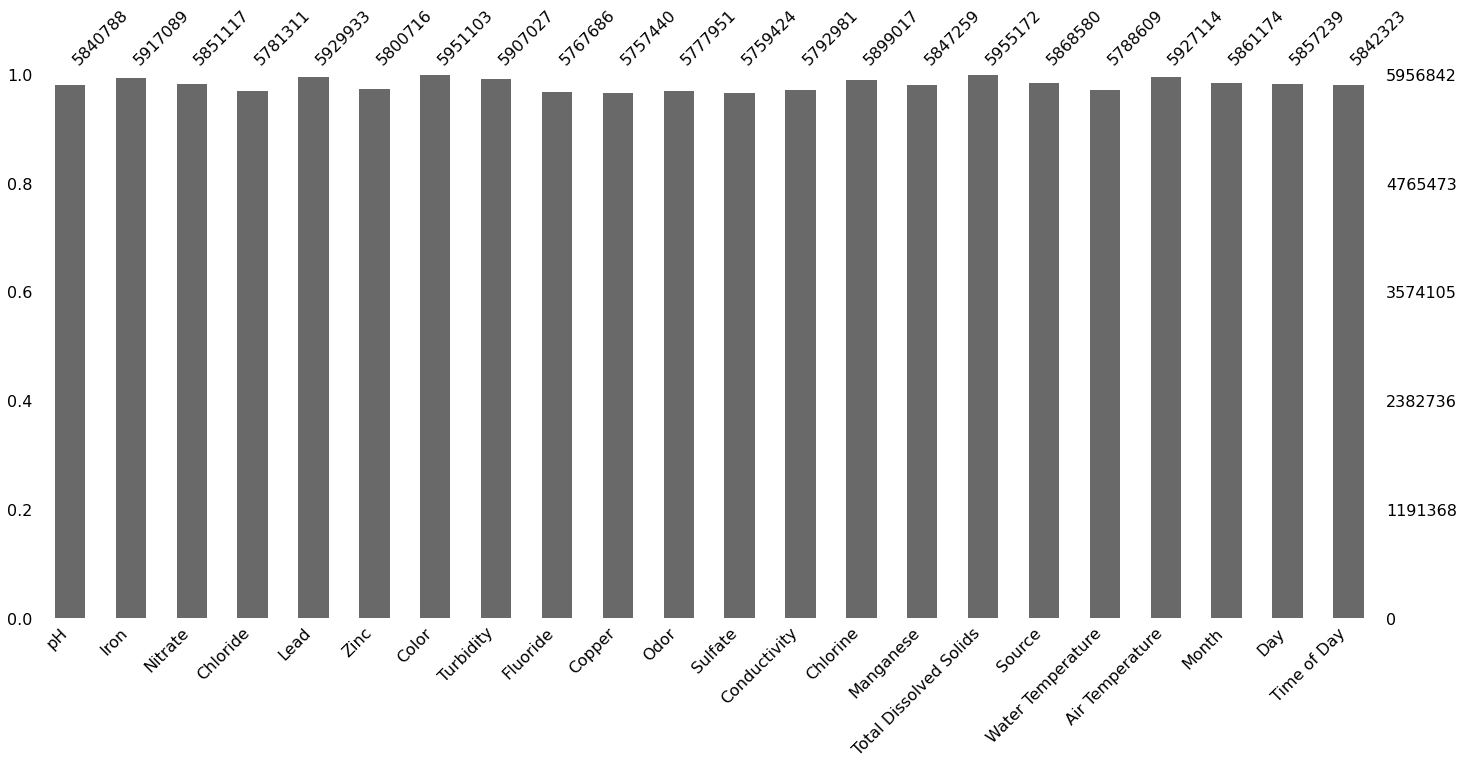

In [9]:
msno.bar(data.drop(columns=['Index','Target']))

### Let's explore the null values correlation using heatmap.Null correlation explains how strong the non null values and null values strongly afftect the another columns.

<AxesSubplot:>

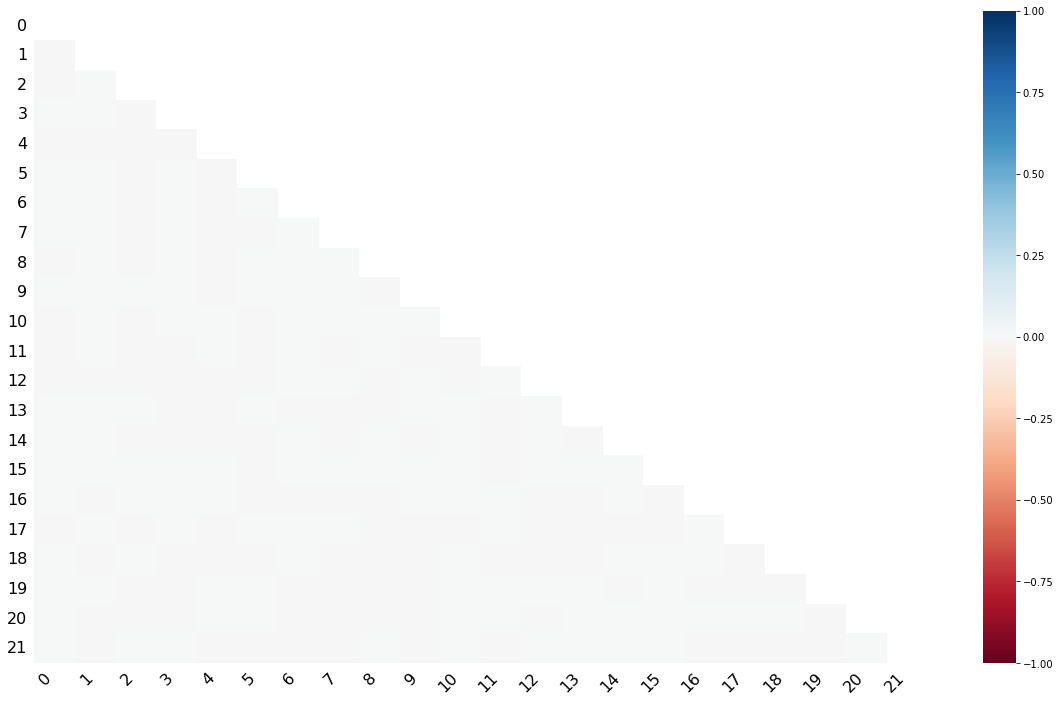

In [10]:
msno.heatmap(data.drop(columns=['Index','Target']))

#### The abov heatmap explains that thers is null value correlation between the columns.

#### Let's explore the null values using the dendrogram.The dendrogram reveal deeper null value trends.

<AxesSubplot:>

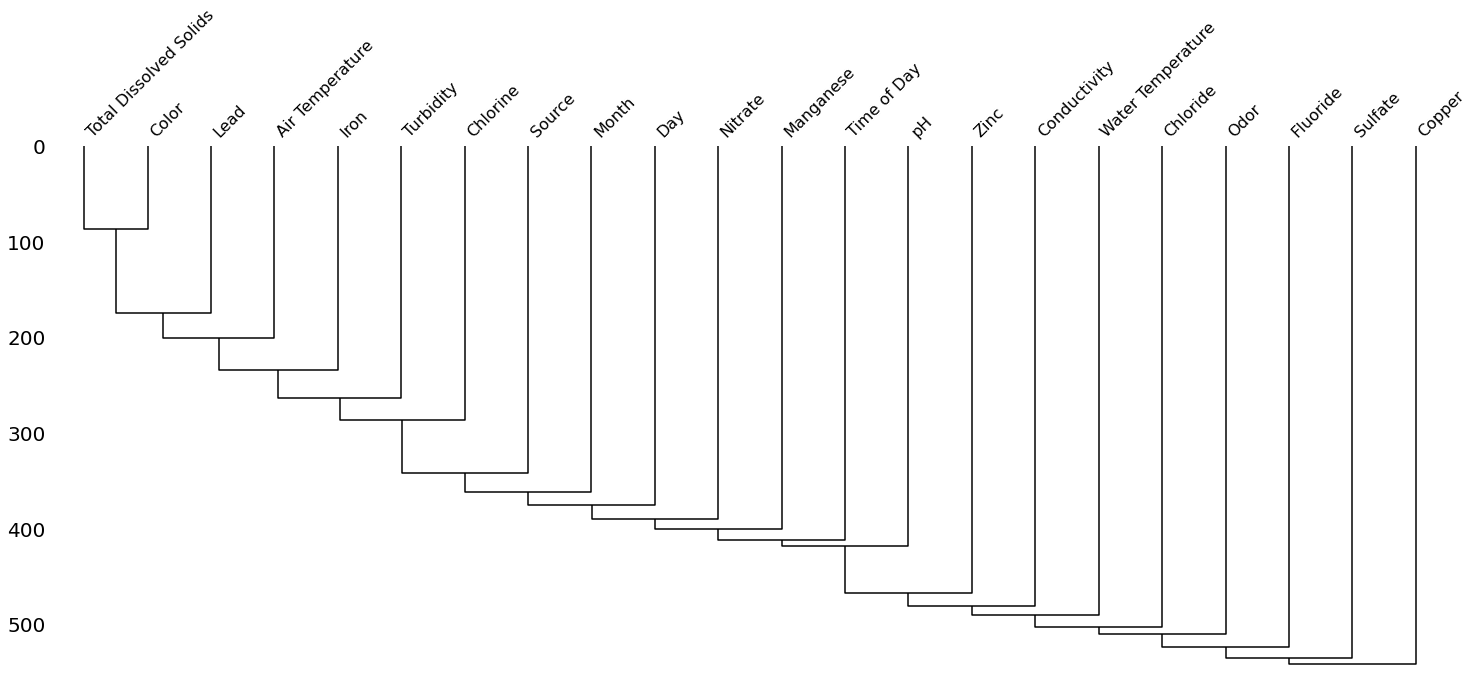

In [11]:
msno.dendrogram(data.drop(columns=['Index','Target']))

#### The above dendrogram explains that there are no columns grouped at level zero and the dataset columns null values are less likely correlated between th columns.

### Let's see some samples from dataset.

In [12]:
data.head()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,0,8.332988,0.000083,8.605777,122.799772,3.713298e-52,3.434827,Colorless,0.022683,0.607283,...,3.708178,2.269945e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0,0
1,1,6.917863,0.000081,3.734167,227.029851,7.849262e-94,1.245317,Faint Yellow,0.019007,0.622874,...,3.292038,8.024076e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0
2,2,5.443762,0.020106,3.816994,230.995630,5.286616e-76,0.528280,Light Yellow,0.319956,0.423423,...,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0,0
3,3,7.955339,0.143988,8.224944,178.129940,3.997118e-176,4.027879,Near Colorless,0.166319,0.208454,...,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0,0
4,4,8.091909,0.002167,9.925788,186.540872,4.171069e-132,3.807511,Light Yellow,0.004867,0.222912,...,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0,0


### Let's explore the Target column distribution.

<AxesSubplot:ylabel='count'>

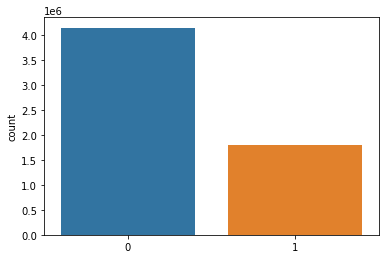

In [13]:
sns.countplot(x=data['Target'].values)

In [14]:
data['Target'].value_counts()

0    4151590
1    1805252
Name: Target, dtype: int64

#### The above plot explains that there is an imbalance between the classes.

### Let's see the distribution of water's pH value.

In [15]:
def box_plot(df,col,rot=None):
  _=plt.figure(figsize=(8,6))
  _=sns.boxplot(y=df[col])
  _=plt.title(col.capitalize()+" Distribution",fontsize=25)
  _=plt.ylabel(col,fontsize=20,rotation=rot)
  _=plt.yticks(fontsize=14)

In [16]:
def side_by_side_plot(df,grp,valcol,rot=None,title=""):
    clr="Paired"
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,8))
    fig.tight_layout()
    sns.kdeplot(x=df[valcol].values, hue=df[grp].values,ax=ax1,palette=clr)
    ax1.set_title(grp.capitalize()+" Wise "+title+" Distribution",size=15)
    ax1.set_xlabel(valcol,fontsize=20)
    sns.boxplot(x=df[grp].values,y=df[valcol].values,ax=ax2,palette=clr)
    ax2.set_title(grp.capitalize()+" Wise "+title+" Distribution",size=15)
    ax2.set_xlabel(grp,fontsize=20)
    ax2.tick_params(rotation=rot)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


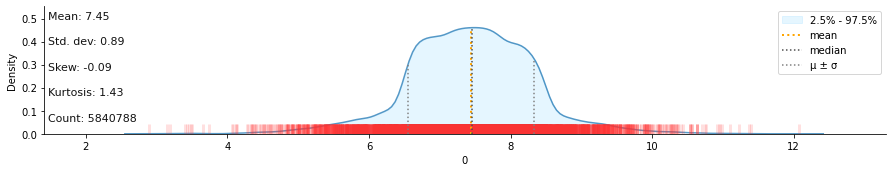

In [17]:
klib.dist_plot(data['pH']);

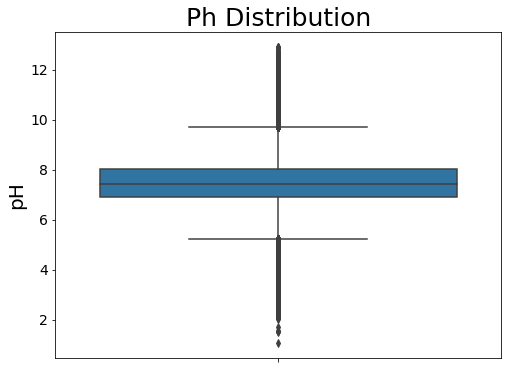

In [18]:
box_plot(data,'pH',rot=90)

In [19]:
data['pH'].describe()

count    5.840788e+06
mean     7.445373e+00
std      8.881665e-01
min      1.057113e+00
25%      6.894328e+00
50%      7.449564e+00
75%      8.014424e+00
max      1.291072e+01
Name: pH, dtype: float64

#### The above histogram plot explain that the Ph column is normally distributed(but slightly negative skew).
#### The pH value of water ranges from 1.06 to 12.910.
#### The average pH value of water is 7.445
#### The boxplot explains that there are outliers above the third quartile and below the first quartile

### Let's see from what are the places the water samples are collected.

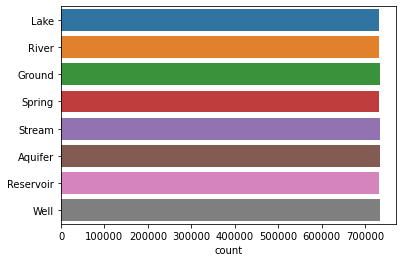

In [20]:
sns.countplot(y=data['Source'].values);

In [21]:
data['Source'].value_counts()

Stream       734502
Ground       734389
Well         734315
Aquifer      733778
Reservoir    733298
River        732980
Spring       732700
Lake         732618
Name: Source, dtype: int64

### The above plot explains that almost same amount of water samples are collected from different water sources.

### Let's see are there any differences in pH value of water colected from different sources.

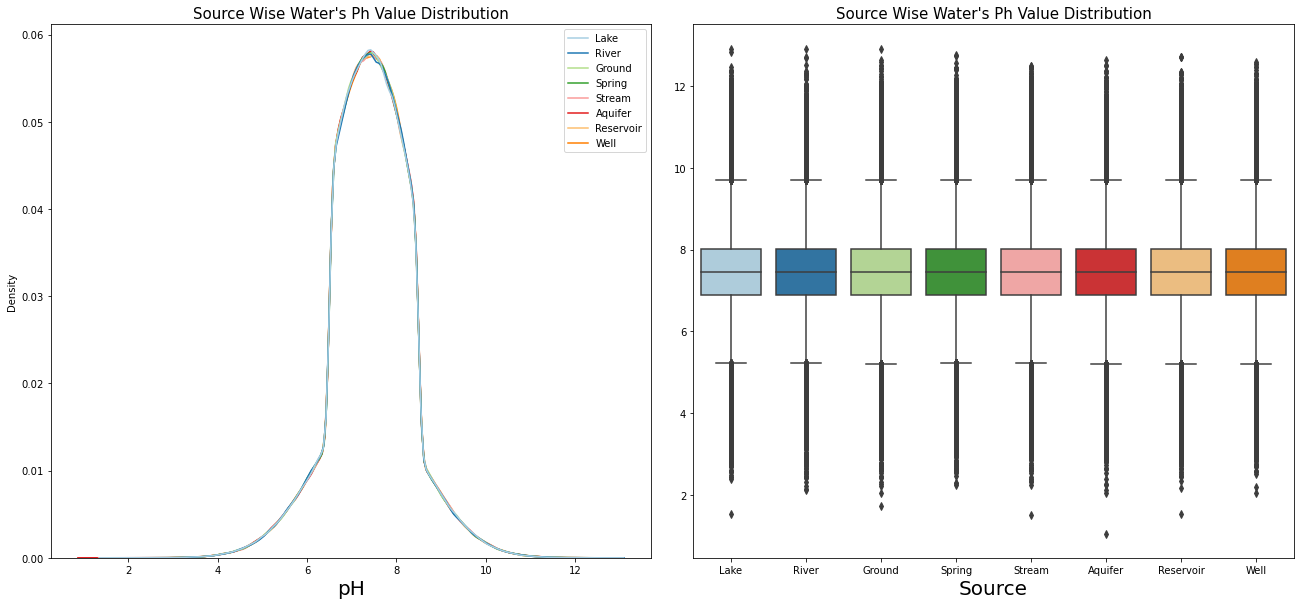

In [22]:
side_by_side_plot(data,'Source','pH',title="Water's Ph Value");

In [23]:
data.groupby('Color')['pH'].describe()

,count,mean,std,min,25%,50%,75%,max
Color,,,,,,,,
Colorless,1753441.0,7.456559,0.792114,1.723405,6.940597,7.458466,7.984262,12.896983
Faint Yellow,1058603.0,7.442031,0.915296,1.057113,6.879212,7.444875,8.023993,12.713397
Light Yellow,743235.0,7.425378,1.030648,2.111165,6.793219,7.432942,8.078813,12.750726
Near Colorless,1751417.0,7.456533,0.792520,2.039464,6.940807,7.457740,7.983834,12.910719
Yellow,528472.0,7.406081,1.171222,1.542348,6.637421,7.409263,8.181254,12.891960


#### The above plot and summary indicate that there are no significant differences between the source of the water and its pH measures.

### Let's see the different water colors.

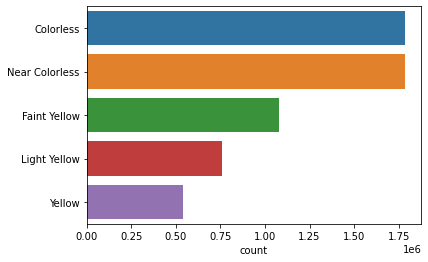

In [24]:
sns.countplot(y=data['Color'].values,order=data['Color'].value_counts().index);

In [25]:
data['Color'].value_counts()

Colorless         1787911
Near Colorless    1786234
Faint Yellow      1079772
Light Yellow       758138
Yellow             539048
Name: Color, dtype: int64

#### The above chart indicates that most of the water samples from various sources are either colorless or near colorless.

### Let's see are there any differences in pH value of water and the color of water.

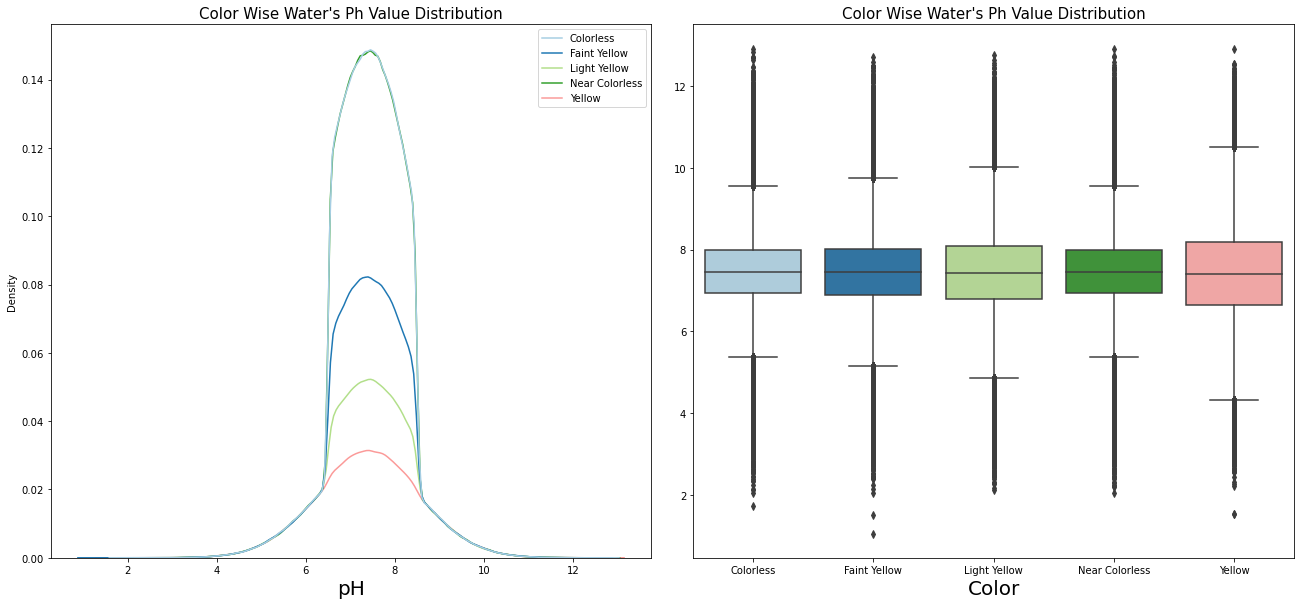

In [26]:
side_by_side_plot(data,'Color','pH',title="Water's Ph Value");

#### The above plot and summary indicate that there are no significant differences between the color of the water and its pH measures.

#### Let's see if is there any change in water pH value distribution by comparing with the source of water and the color of the water.

In [27]:
def water_source_color_measure(df,valcol):
    fig=plt.subplots(figsize=(20, 20))
    for i,cat  in enumerate(['Lake', 'River', 'Ground', 'Spring', 'Stream', 'Aquifer','Reservoir', 'Well']):
        _=plt.subplot(4,2,i+1)
        _=sns.boxplot(x=df[df['Source']==cat]['Color'].values,y=df[df['Source']==cat][valcol].values)
        _=plt.title(f"{cat} Water's {valcol} Value Distribution by Different Color",fontsize=15)
        _=plt.xticks(fontsize=15)
        _=plt.tight_layout()  
    plt.show()  

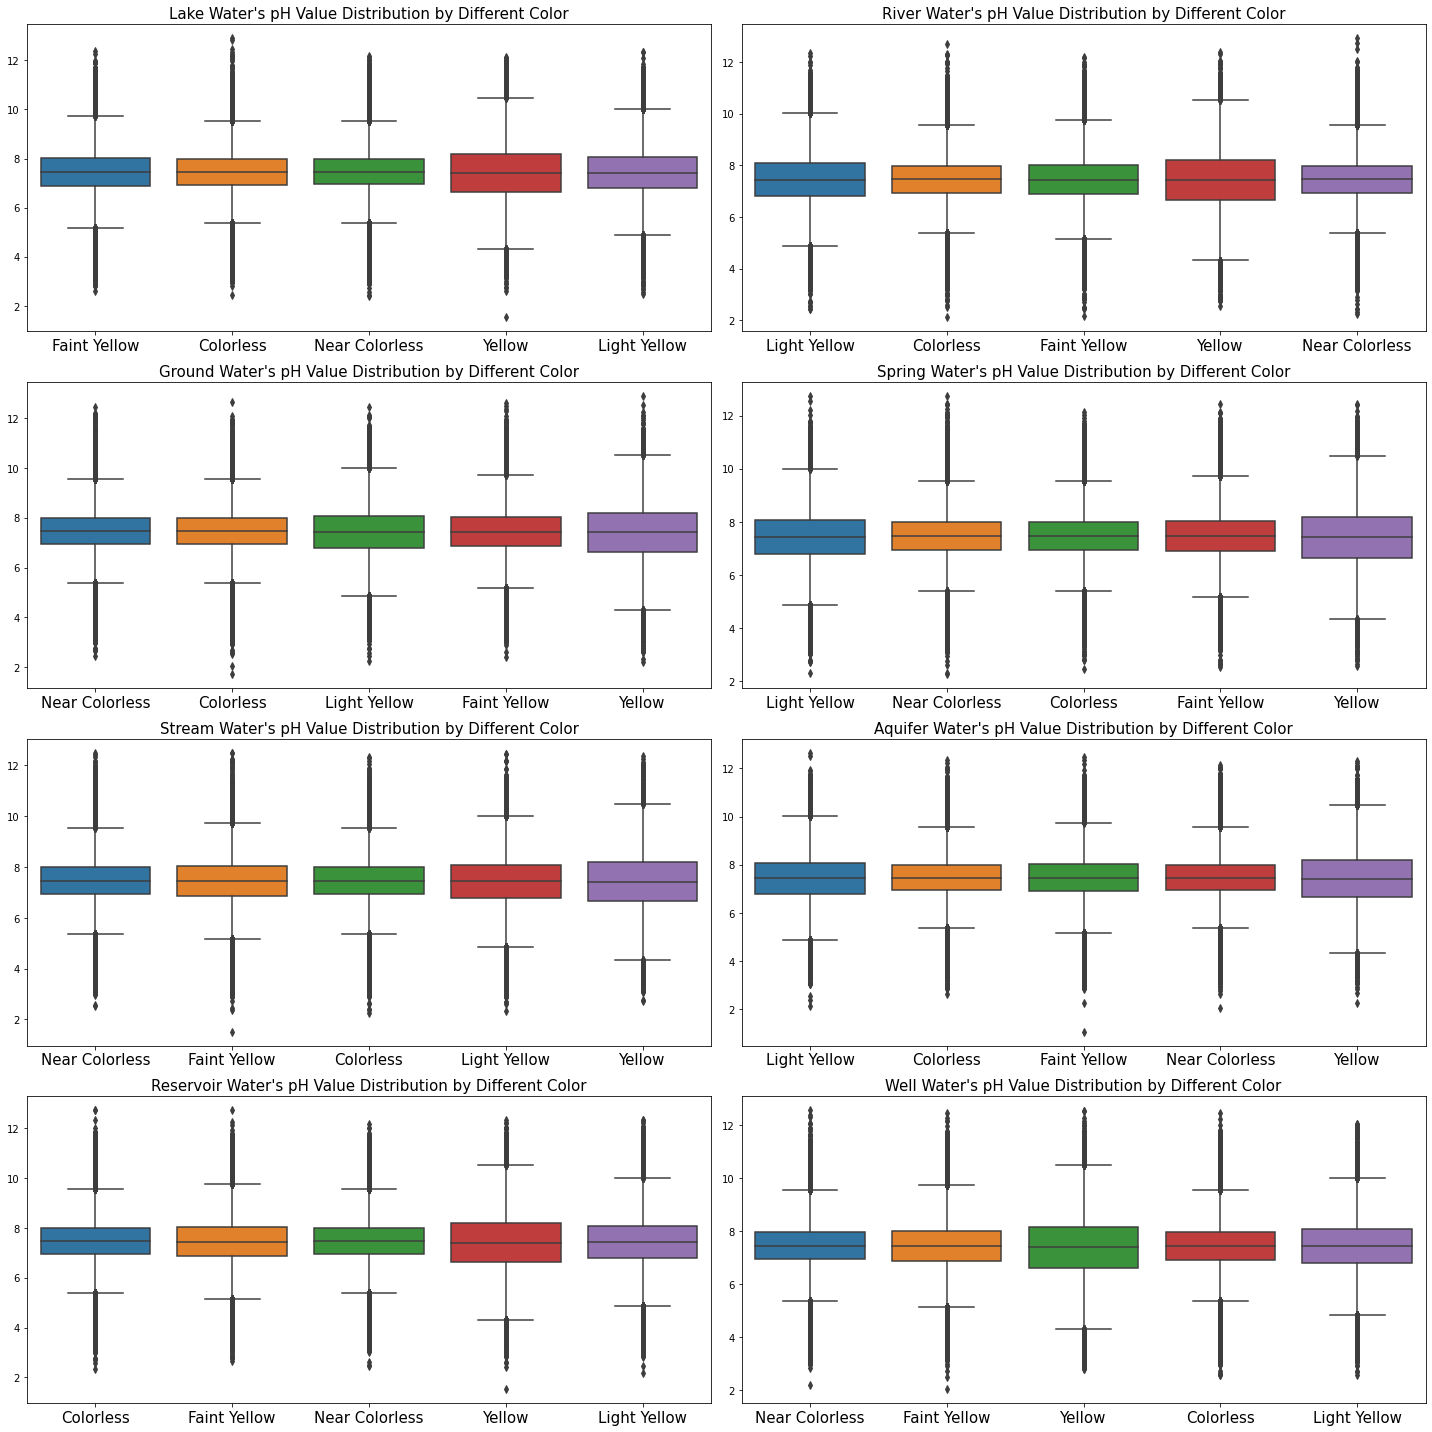

In [28]:
water_source_color_measure(data,'pH');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on pH value.

### Let's see the water's pH value distribution by the target class.

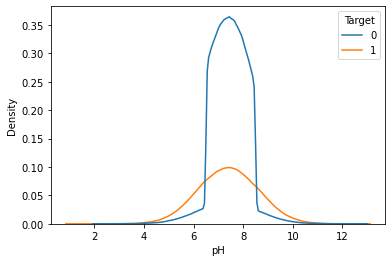

In [29]:
sns.kdeplot(x=data['pH'],hue=data['Target']);

In [30]:
data.groupby('Target')['pH'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4070772.0,7.465784,0.701885,2.039464,6.975962,7.463796,7.961706,12.896983
1,1770016.0,7.398431,1.211151,1.057113,6.571202,7.397205,8.221192,12.910719


#### The above plot and summary indicate the pH value is not alone sufficient for determining whether the water is drinkable or not. Although, the pH value is an important indicator of water quality.

### Let's see the distribution of water's Iron value(mscg/dl).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


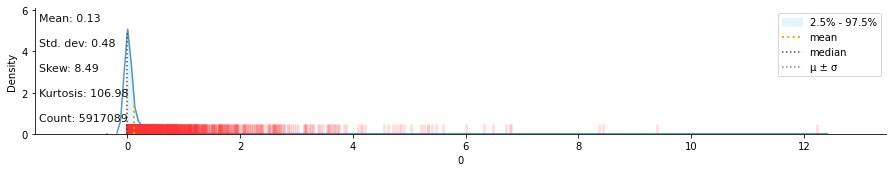

In [31]:
klib.dist_plot(data['Iron']);

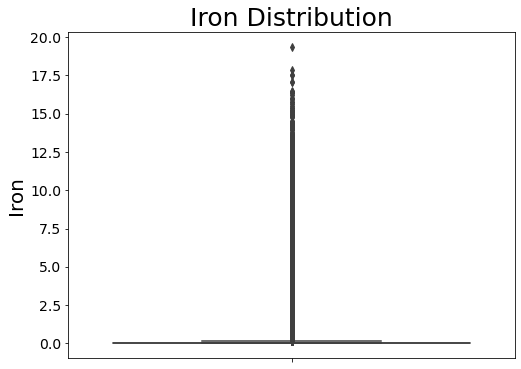

In [32]:
box_plot(data,'Iron',rot=90);

In [33]:
data['Iron'].describe()

count    5.917089e+06
mean     1.279027e-01
std      4.799915e-01
min      2.047587e-53
25%      9.992949e-06
50%      2.249640e-03
75%      5.455290e-02
max      1.935315e+01
Name: Iron, dtype: float64

#### The above histogram plot explain that the Iron column is positively skewed.
#### Water's iron value ranges from 0.0 to 1.194.
#### The average iron value of water is 0.1279027
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water iron value distribution by comparing with the source of water and the color of the water.

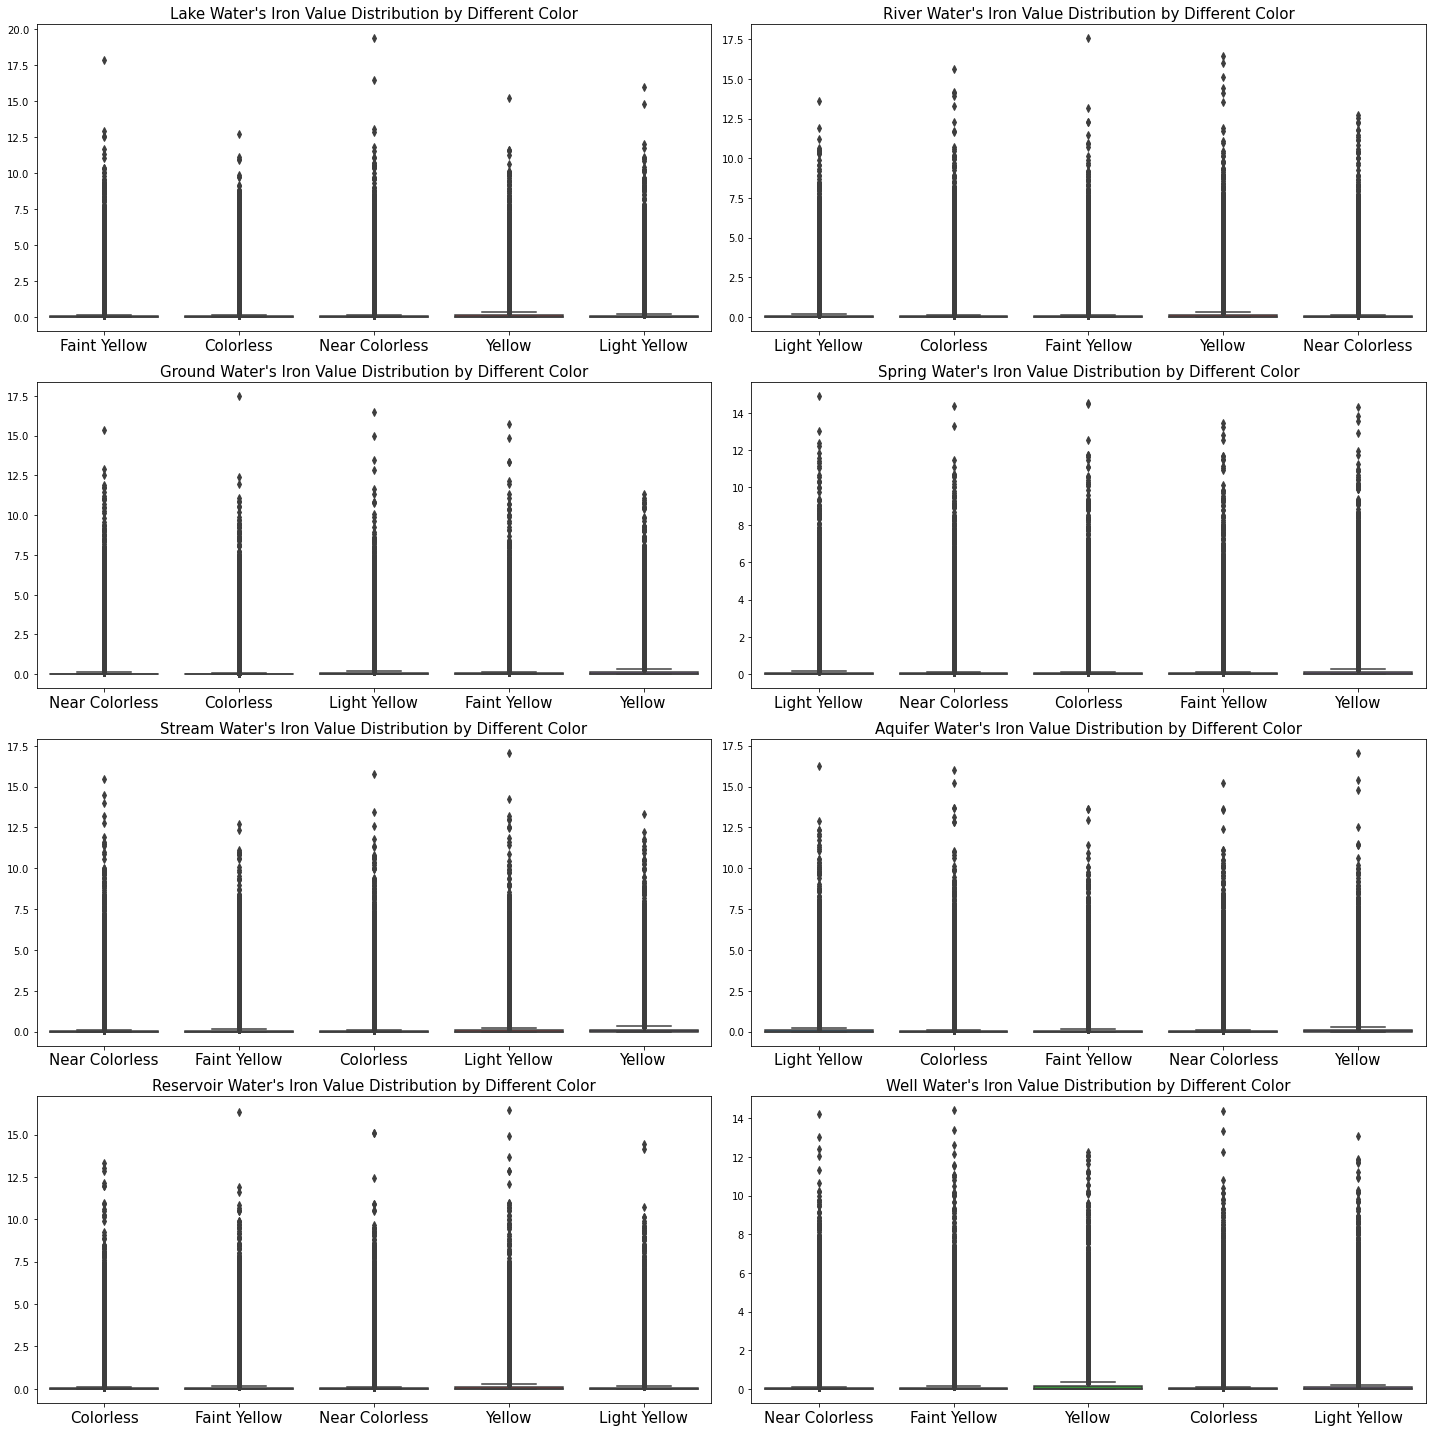

In [34]:
water_source_color_measure(data,'Iron');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on iron value.

### Let's see the water's iron value distribution by the target class.

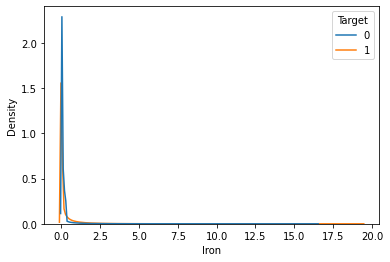

In [35]:
sns.kdeplot(x=data['Iron'],hue=data['Target']);

In [36]:
data.groupby('Target')['Iron'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4123948.0,0.070651,0.309824,2.047587e-53,0.000007,0.001550,0.037329,16.495324
1,1793141.0,0.259573,0.717369,3.264524e-48,0.000025,0.005704,0.143875,19.353145


#### The above plot and summary indicate the iron value is not alone sufficient for determining whether the water is drinkable or not. Although, the iron value is an important indicator of water quality.

### Let's see the distribution of water's nitrate value(ppm).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


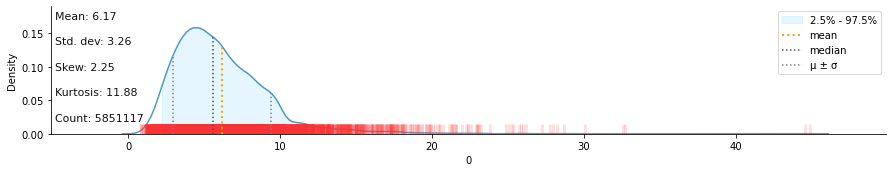

In [37]:
klib.dist_plot(data['Nitrate']);

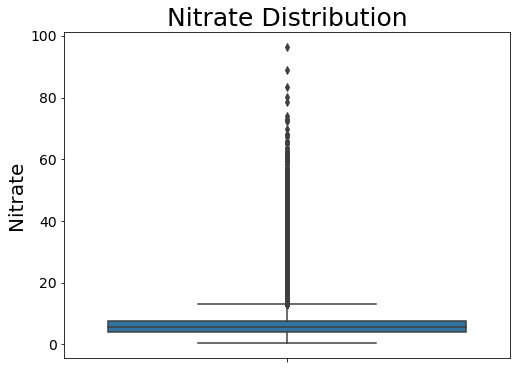

In [38]:
box_plot(data,'Nitrate',rot=90);

In [39]:
data['Nitrate'].describe()

count    5.851117e+06
mean     6.169970e+00
std      3.256667e+00
min      2.861727e-01
25%      3.973078e+00
50%      5.604051e+00
75%      7.672402e+00
max      9.639078e+01
Name: Nitrate, dtype: float64

#### The above histogram plot explain that the nitrate column is positively skewed.
#### Water's nitrate value ranges from 0.2862 to 96.391.
#### The average nitrate value of water is 6.16997.
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water nitrate value distribution by comparing with the source of water and the color of the water.

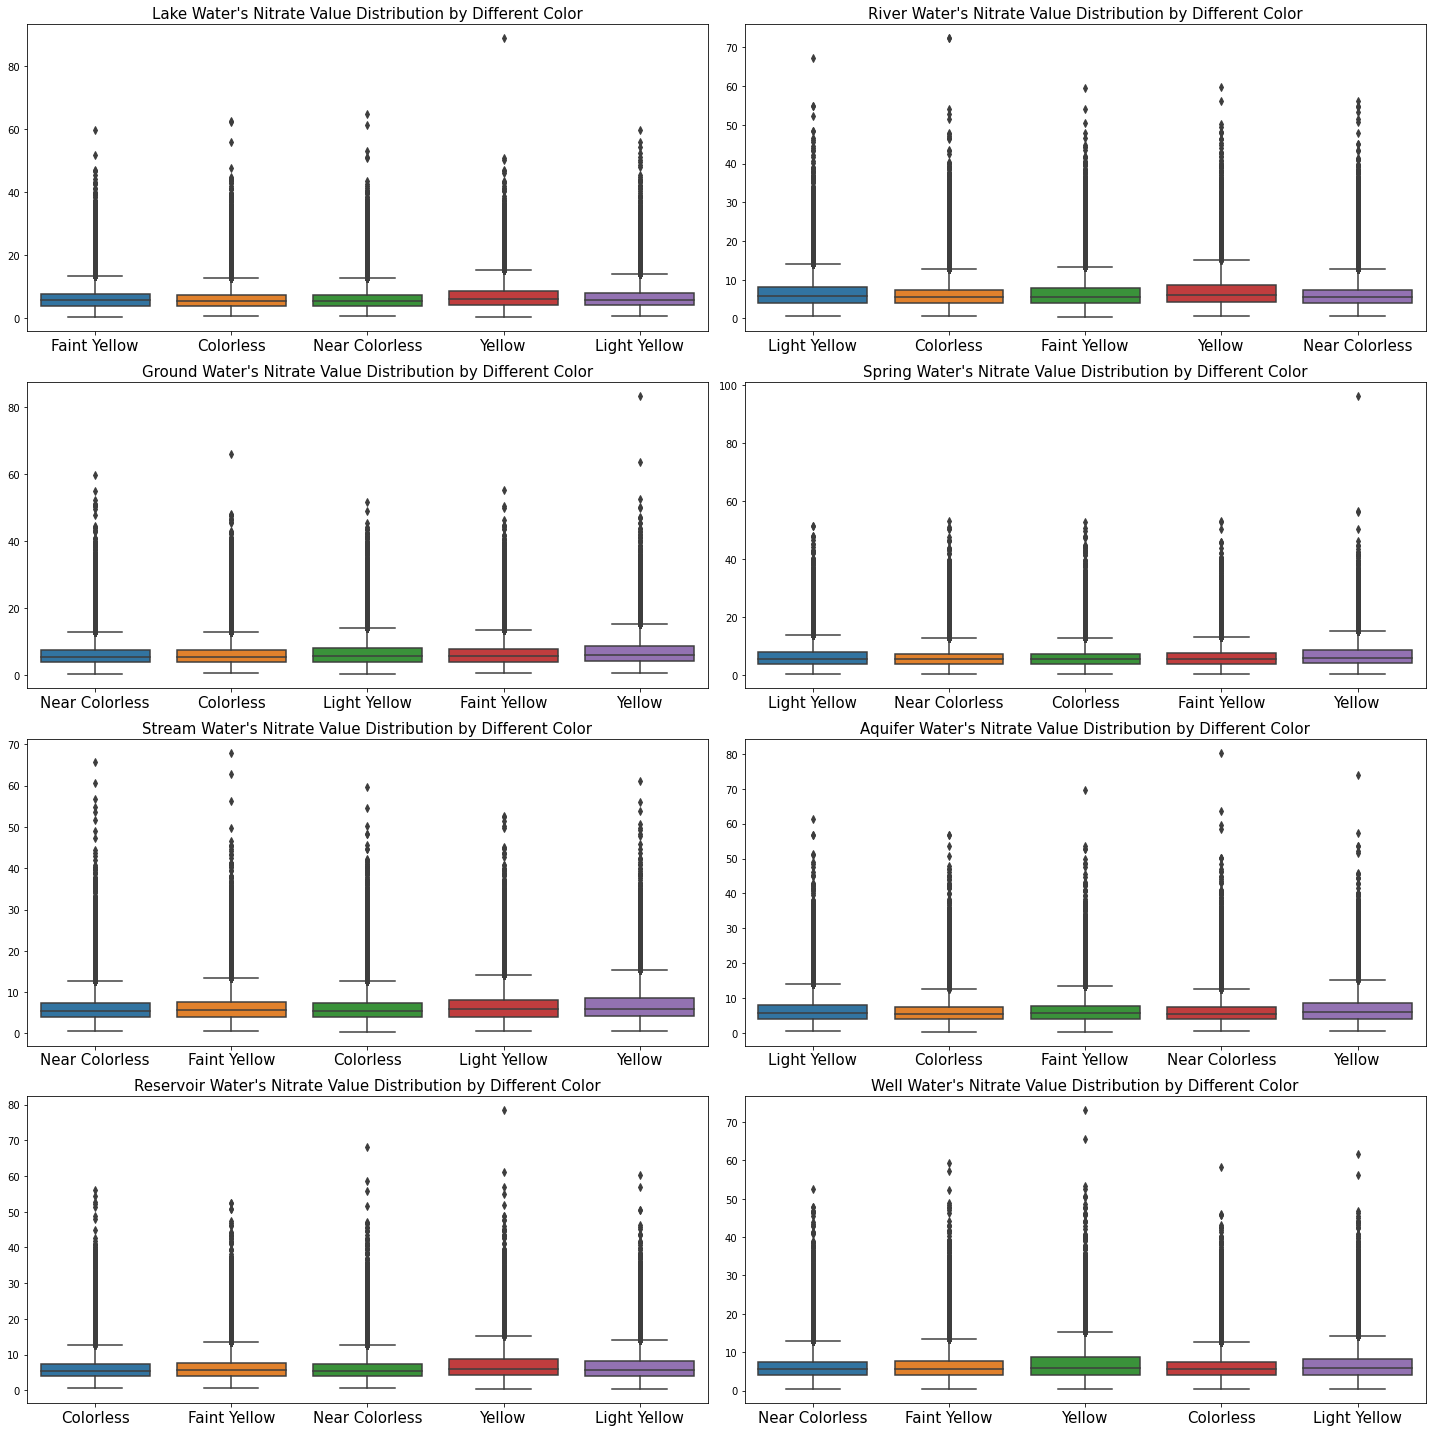

In [40]:
water_source_color_measure(data,'Nitrate');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on nitrate value.

### Let's see the water's nitrate value distribution by the target class.


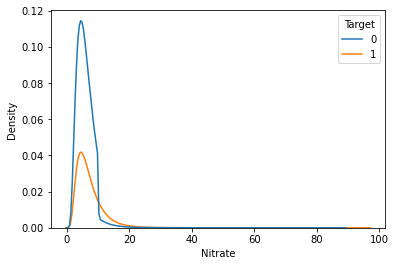

In [41]:
sns.kdeplot(x=data['Nitrate'],hue=data['Target']);

In [42]:
data.groupby('Target')['Nitrate'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4077946.0,5.776196,2.642982,0.286173,3.894127,5.438066,7.318225,88.813035
1,1773171.0,7.075573,4.213747,0.341463,4.185279,6.074897,8.831979,96.390779


#### The above plot and summary indicate the nitrate value is not alone sufficient for determining whether the water is drinkable or not. Although, the nitrate value is an important indicator of water quality.

### Let's see the distribution of water's chloride value(mEq/L).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


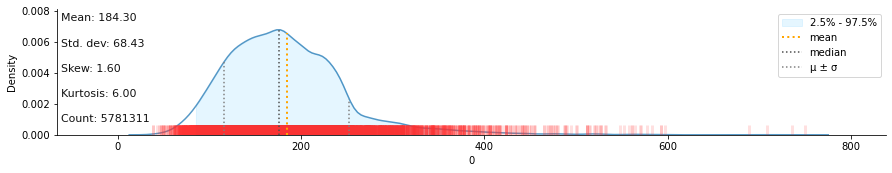

In [43]:
klib.dist_plot(data['Chloride']);

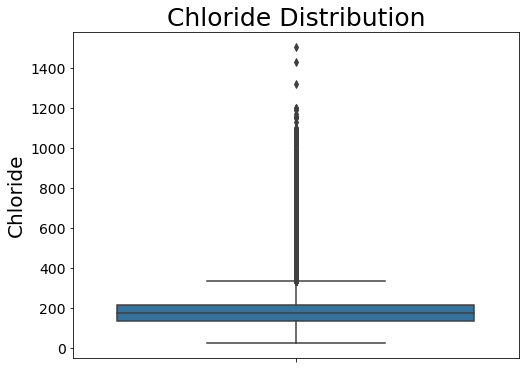

In [44]:
box_plot(data,'Chloride',rot=90);

In [45]:
data['Chloride'].describe()

count    5.781311e+06
mean     1.842970e+02
std      6.842828e+01
min      2.363919e+01
25%      1.381341e+02
50%      1.760178e+02
75%      2.179811e+02
max      1.507310e+03
Name: Chloride, dtype: float64

#### The above histogram plot explain that the chloride column is positively skewed.
#### Water's chloride value ranges from 23.64 to 1507.31.
#### The average chloride value of water is 18.43
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water chloride value distribution by comparing with the source of water and the color of the water.


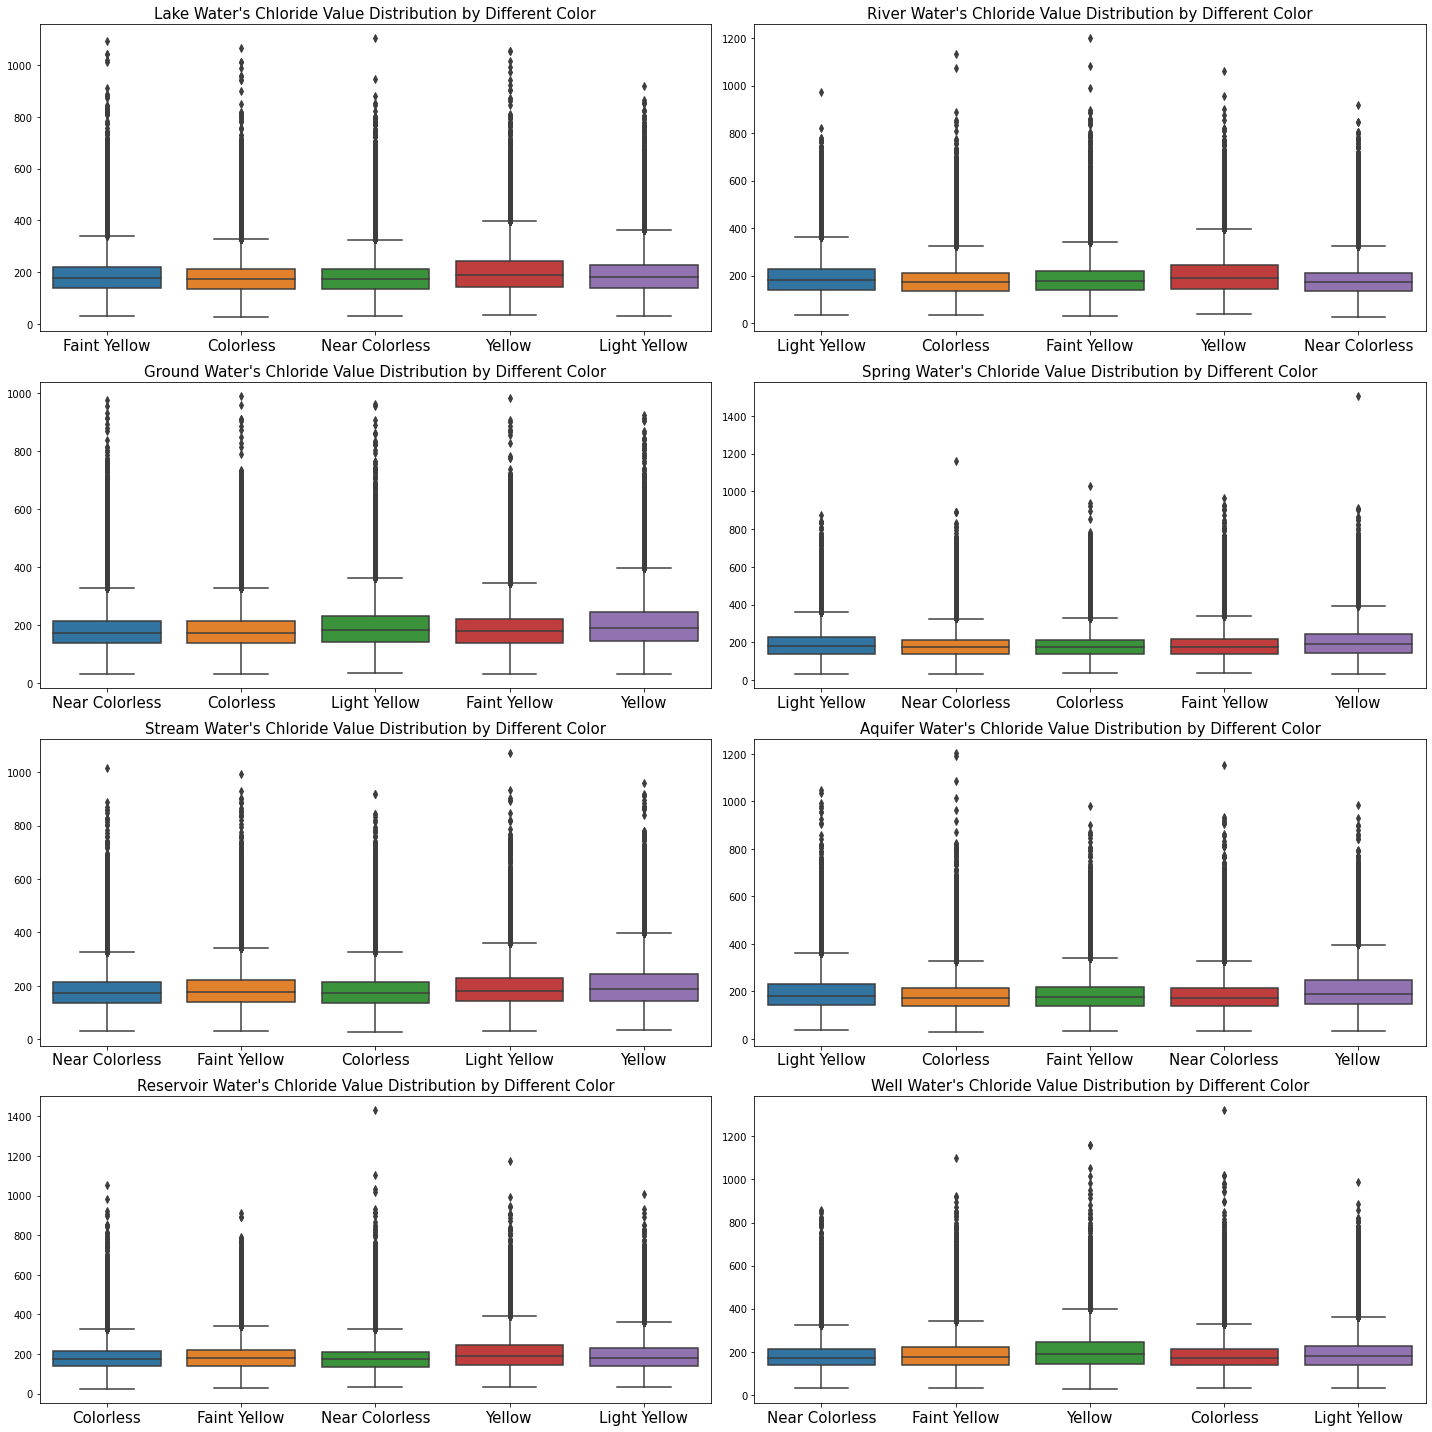

In [46]:
water_source_color_measure(data,'Chloride');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on Chloride value.

### Let's see the water's chloride value distribution by the target class.


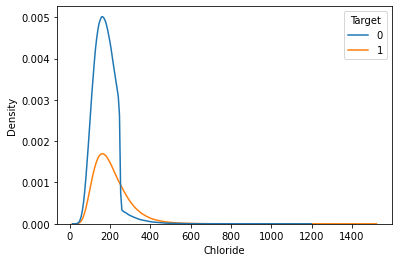

In [47]:
sns.kdeplot(x=data['Chloride'],hue=data['Target']);

In [48]:
data.groupby('Target')['Chloride'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4029032.0,174.228676,55.817877,23.639187,135.405574,171.001904,208.550982,1190.082896
1,1752279.0,207.447129,86.694677,27.513317,145.856748,191.371132,251.456884,1507.309881


#### The above plot and summary indicate the chloride value is not alone sufficient for determining  whether the water is drinkable or not. Although, the chloride value is an important indicator of water quality.

### Let's see the distribution of water's lead value(µg/dL).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


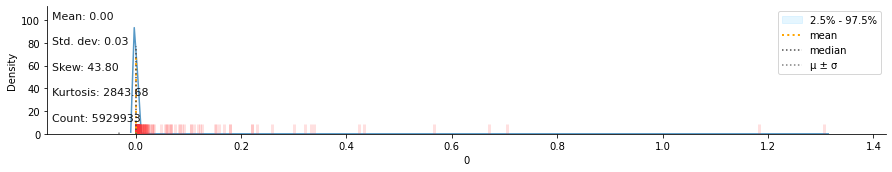

In [49]:
klib.dist_plot(data['Lead']);

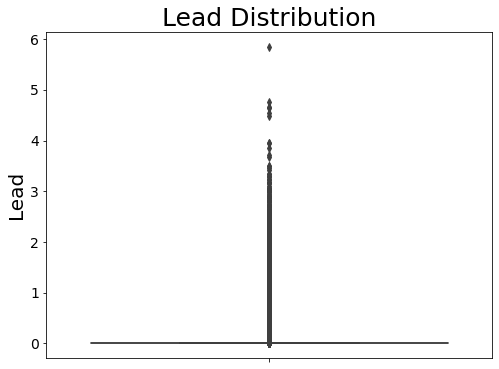

In [50]:
box_plot(data,'Lead',rot=90);

In [51]:
data['Lead'].describe()

count     5.929933e+06
mean      1.498336e-03
std       3.250641e-02
min       0.000000e+00
25%      1.500283e-122
50%       2.213625e-62
75%       3.592165e-27
max       5.844281e+00
Name: Lead, dtype: float64

#### The above histogram plot explain that the lead column is highly positive skewed.
#### Water's lead value ranges from 0.00 to 5.85.
#### The average lead value of water is 0.0015
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water lead value distribution by comparing with the source of water and the color of the water

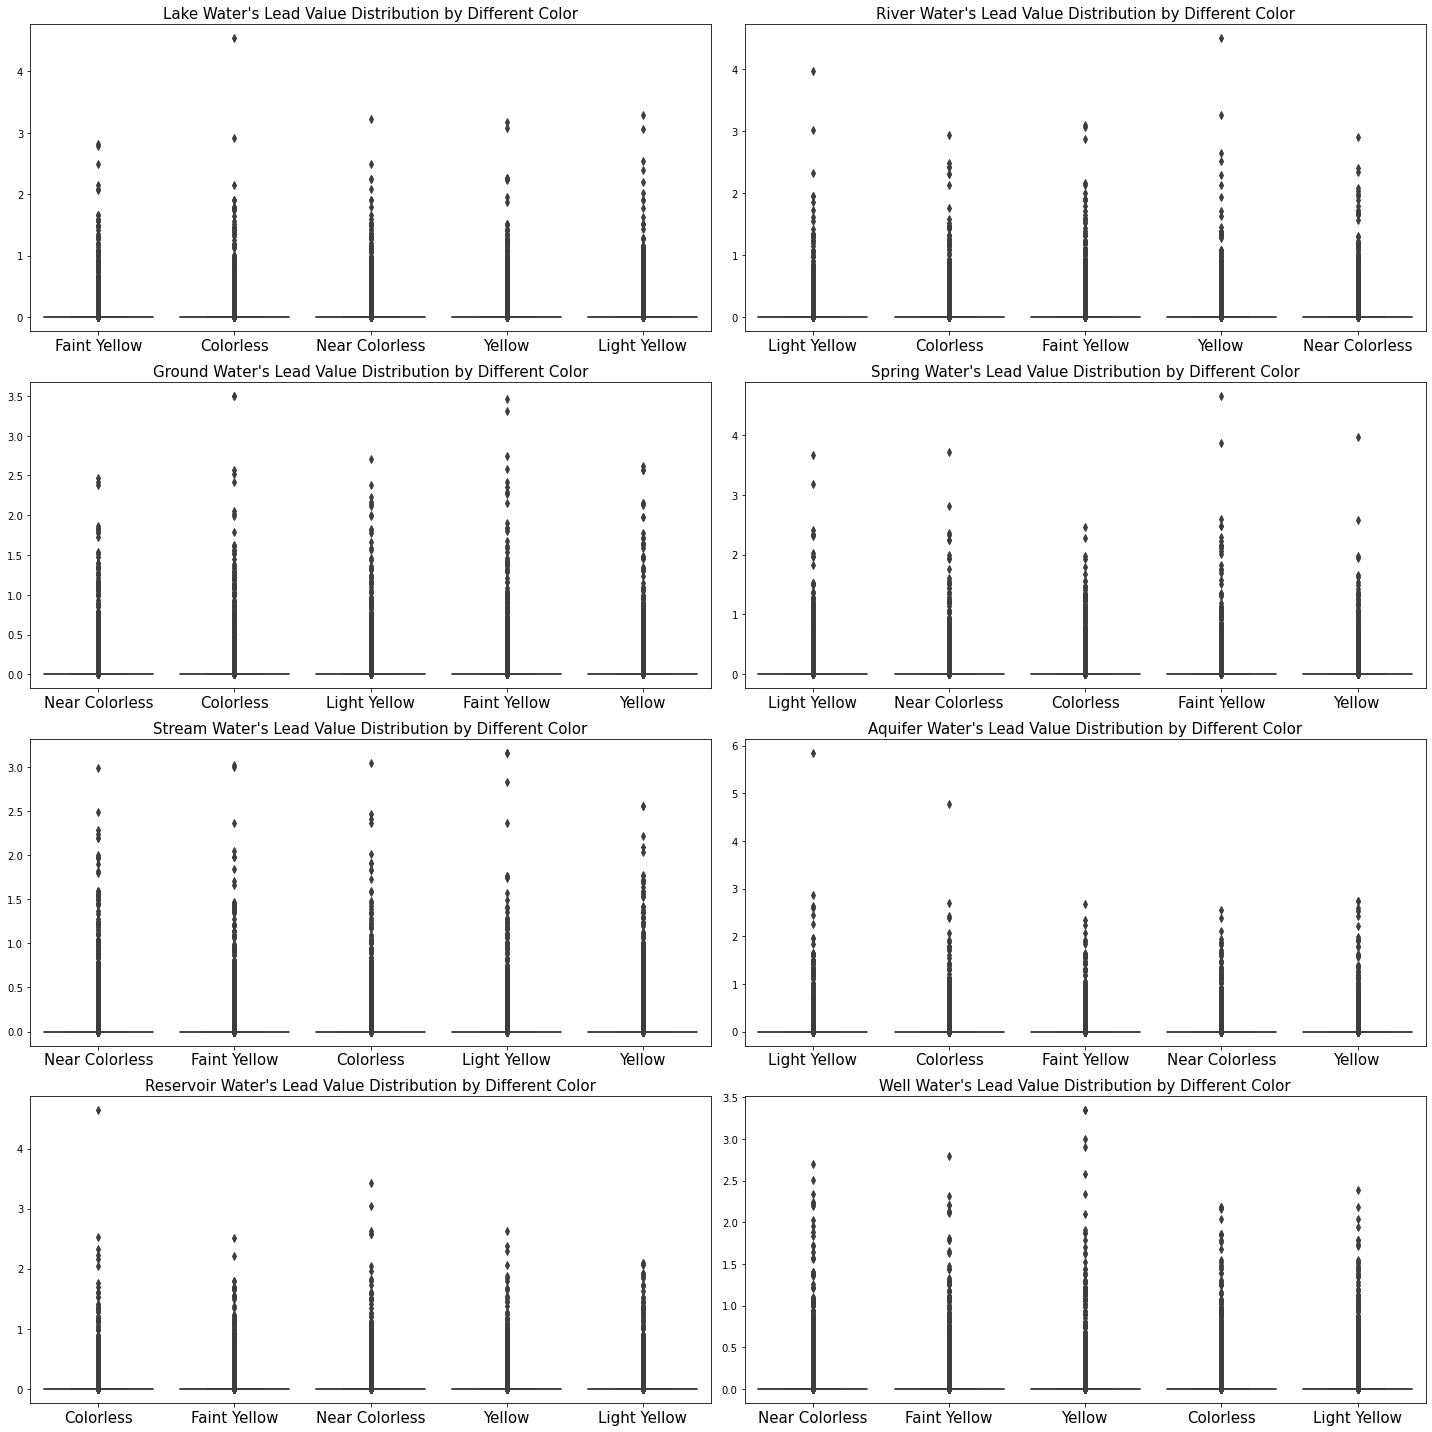

In [52]:
water_source_color_measure(data,'Lead');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on lead value.

### Let's see the water's lead value distribution by the target class.

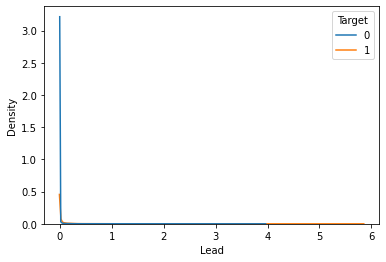

In [53]:
sns.kdeplot(x=data['Lead'],hue=data['Target']);

In [54]:
data.groupby('Target')['Lead'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4132835.0,0.000597,0.019808,0.0,4.950507e-123,7.372039e-63,1.202184e-27,3.959541
1,1797098.0,0.003572,0.050776,0.0,2.075219e-121,2.871356e-61,4.530135e-26,5.844281


#### The above plot and summary indicate the lead value is not alone sufficient for determining whether the water is drinkable or not. Although, the lead value is an important indicator of water quality.

### Let's see the distribution of water's zinc value(µg/mL).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


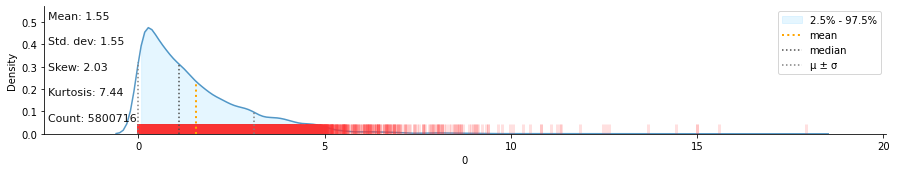

In [55]:
klib.dist_plot(data['Zinc']);

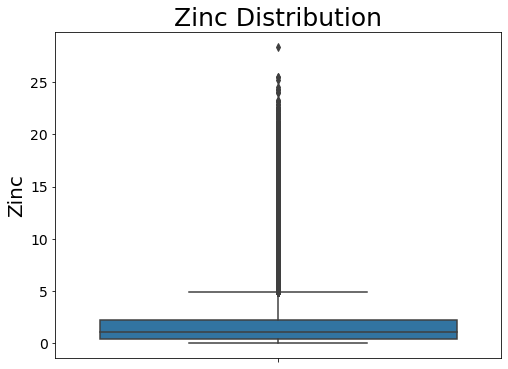

In [56]:
box_plot(data,'Zinc',rot=90);

In [57]:
data['Zinc'].describe()

count    5.800716e+06
mean     1.550255e+00
std      1.546368e+00
min      1.482707e-08
25%      4.148202e-01
50%      1.081818e+00
75%      2.230841e+00
max      2.836867e+01
Name: Zinc, dtype: float64

#### The above histogram plot explain that the zinc column is positively skewed.
#### Water's zinc value ranges from 0.000000015  to 28.4.
#### The average zinc value of water is 1.6.
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water zinc value distribution by comparing with the source of water and the color of the water.


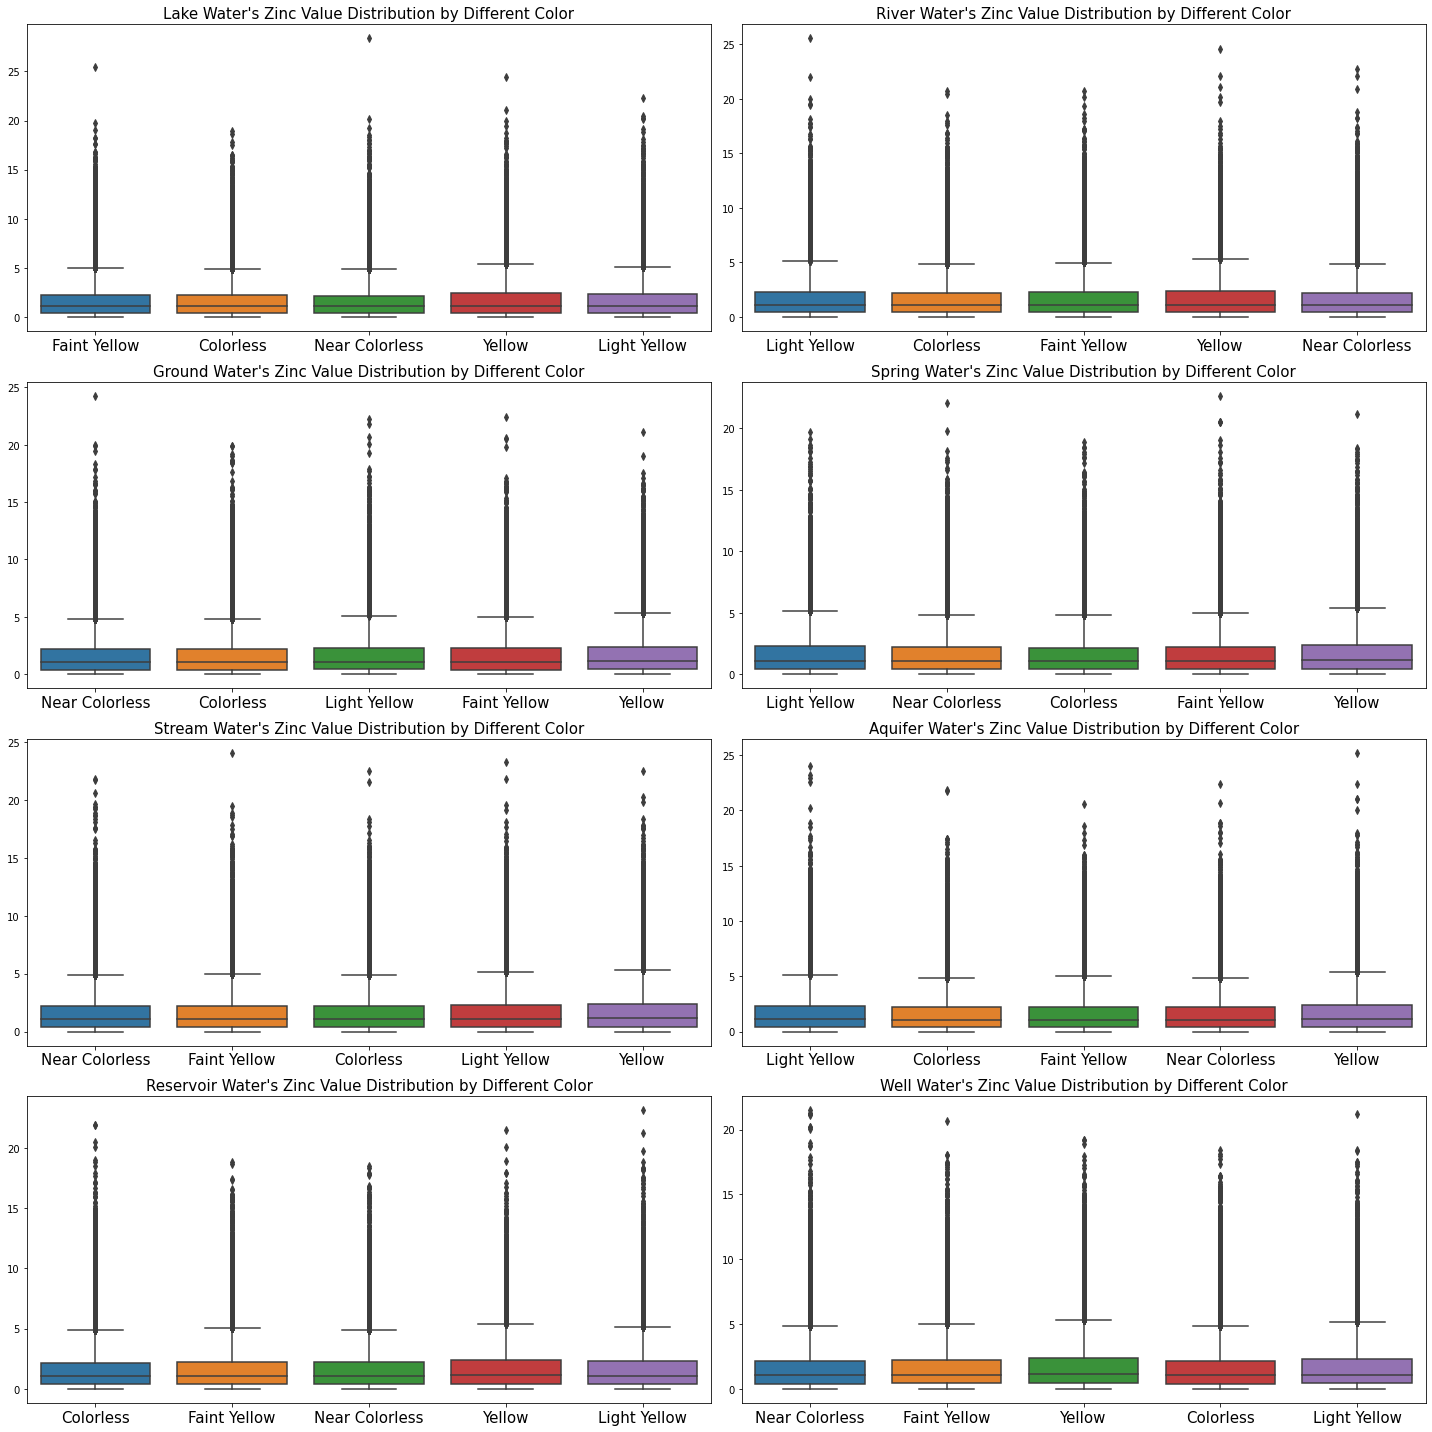

In [58]:
water_source_color_measure(data,'Zinc');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on zinc value.


### Let's see the water's zinc value distribution by the target class.

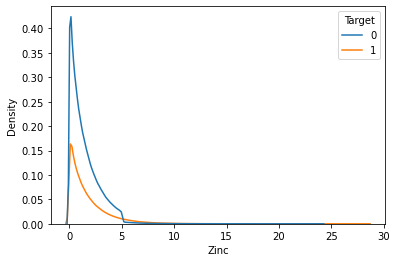

In [59]:
sns.kdeplot(x=data['Zinc'],hue=data['Target']);

In [60]:
data.groupby('Target')['Zinc'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4042938.0,1.460048,1.365767,1.482707e-08,0.406256,1.055186,2.153115,24.072897
1,1757778.0,1.757732,1.881264,8.038141e-08,0.435544,1.148081,2.432361,28.368672


#### The above plot and summary indicate the zinc value is not alone sufficient for determining whether the water is drinkable or not. Although, the zinc value is an important indicator of water quality.

### Let's see the distribution of water's turbidity value(NTU).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


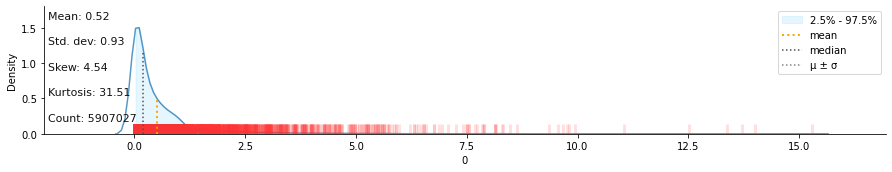

In [61]:
klib.dist_plot(data['Turbidity']);

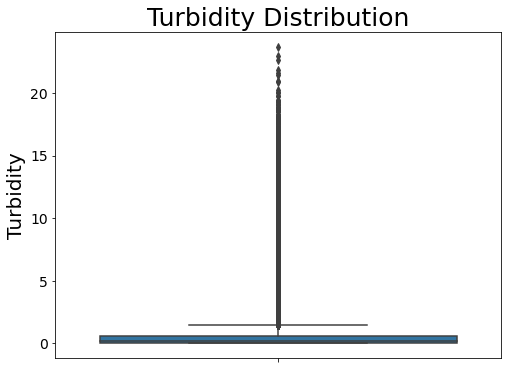

In [62]:
box_plot(data,'Turbidity',rot=90);

In [63]:
data['Turbidity'].describe()

count    5.907027e+06
mean     5.215093e-01
std      9.258807e-01
min      1.029712e-16
25%      3.872368e-02
50%      2.097680e-01
75%      6.249132e-01
max      2.371527e+01
Name: Turbidity, dtype: float64

#### The above histogram plot explain that the turbidity column is positively skewed.
#### Water's turbidity value ranges from 0.0 to 23.72.
#### The average turbidity value of water is 0.0522
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water turbidity value distribution by comparing with the source of water and the color of the water.

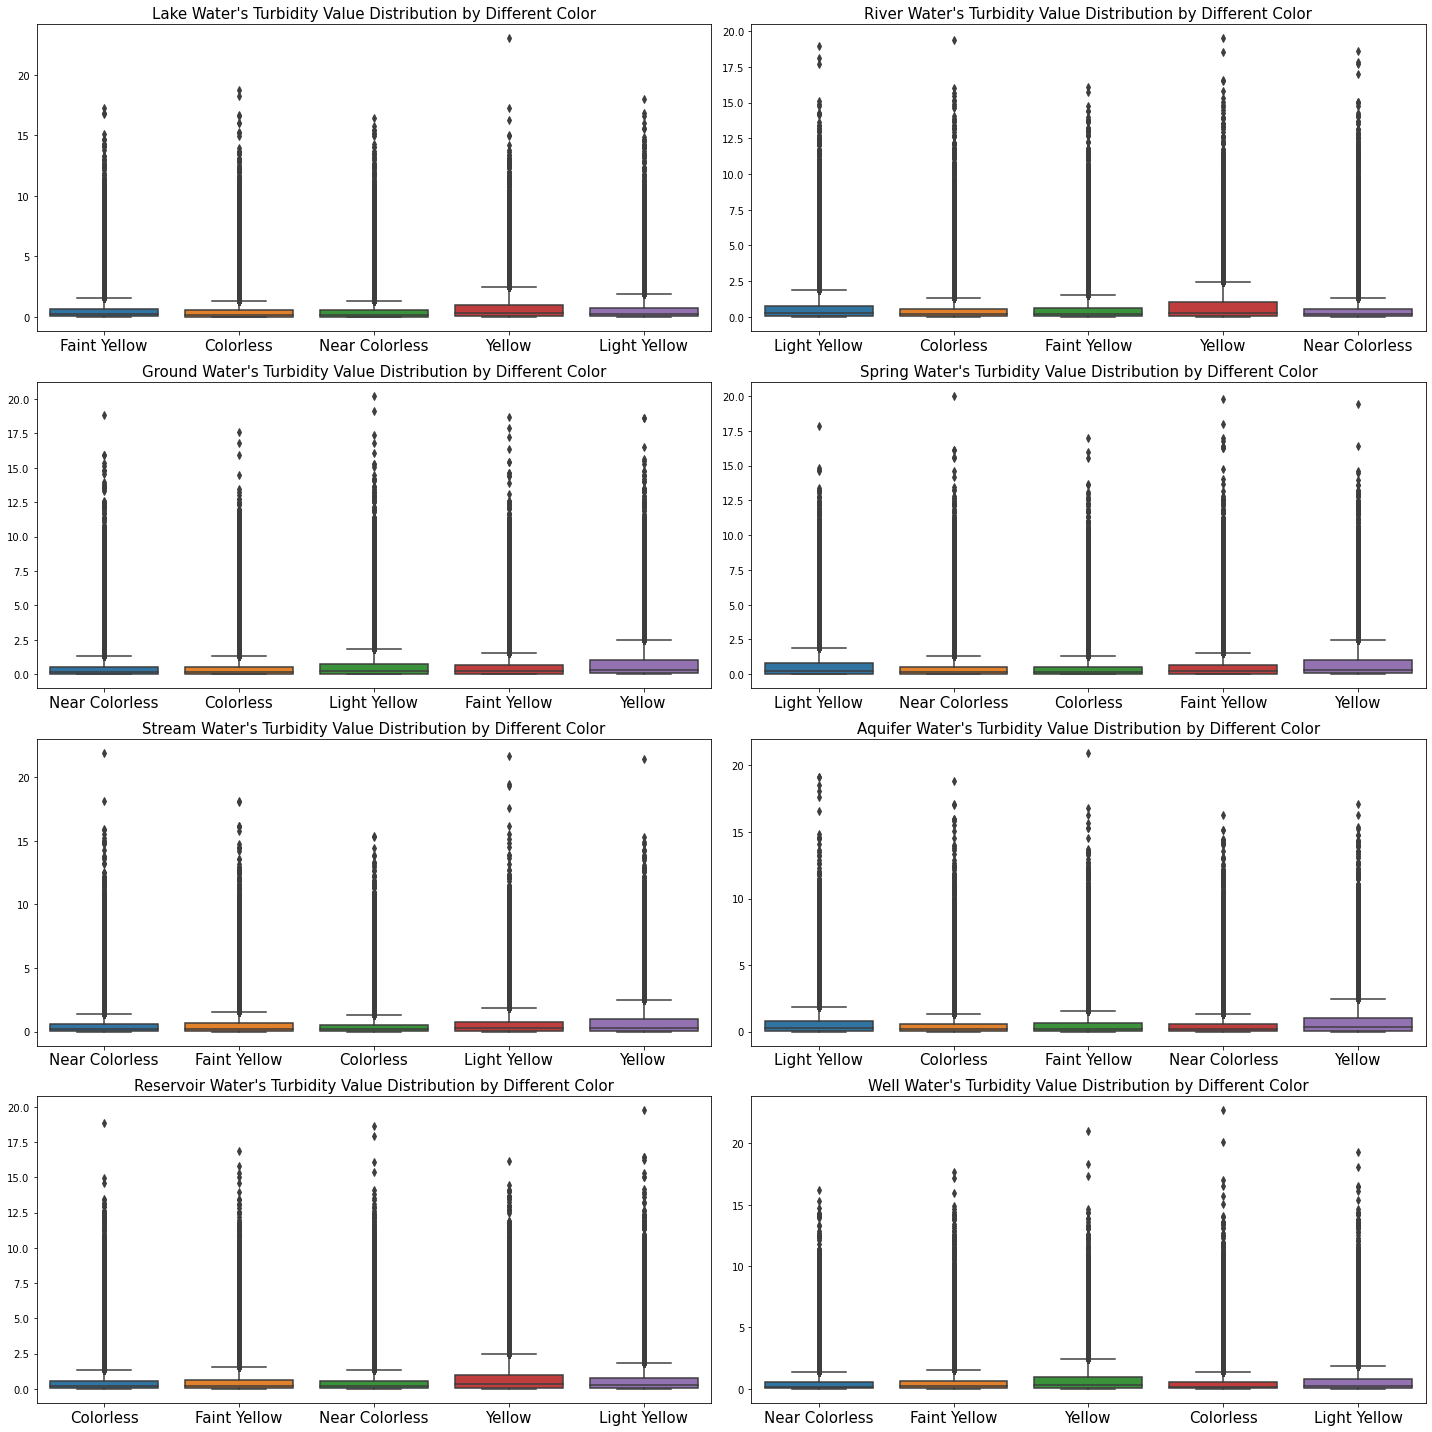

In [64]:
water_source_color_measure(data,'Turbidity');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on turbidity value.

### Let's see the water's turbidity value distribution by the target class.

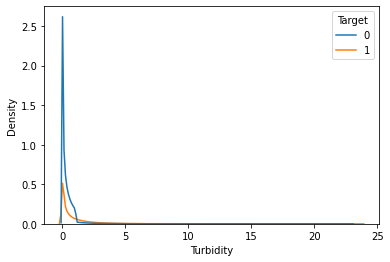

In [65]:
sns.kdeplot(x=data['Turbidity'],hue=data['Target']);

In [66]:
data.groupby('Target')['Turbidity'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4116856.0,0.372225,0.634971,1.029712e-16,0.032740,0.175635,0.510025,23.019798
1,1790171.0,0.864818,1.316192,5.686552e-15,0.060203,0.337466,1.122459,23.715270


#### The above plot and summary indicate the turbidity value is not alone sufficient for determining whether the water is drinkable or not. Although, the turbidity value is an important indicator of water quality.

### Let's see the distribution of water's fluoride value(mg/L).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


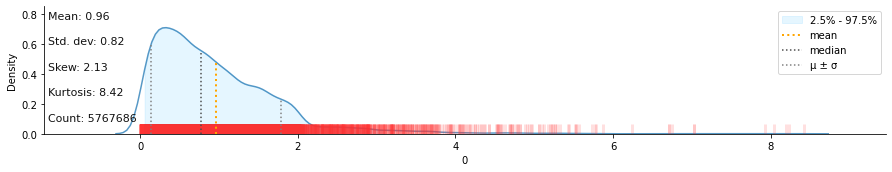

In [67]:
klib.dist_plot(data['Fluoride']);

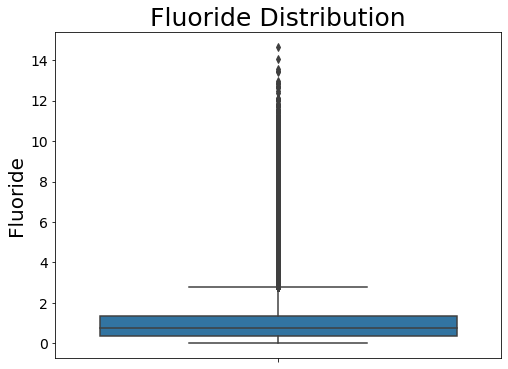

In [68]:
box_plot(data,'Fluoride',rot=90);

In [69]:
data['Fluoride'].describe()

count    5.767686e+06
mean     9.644315e-01
std      8.247870e-01
min      4.550148e-06
25%      3.749503e-01
50%      7.751792e-01
75%      1.341508e+00
max      1.464625e+01
Name: Fluoride, dtype: float64

#### The above histogram plot explain that the flouride column is positively skewed.
#### Water's flouride value ranges from 0.000005 to 14.7.
#### The average flouride value of water is 0.97.
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water fluoride value distribution by comparing with the source of water and the color of the water.

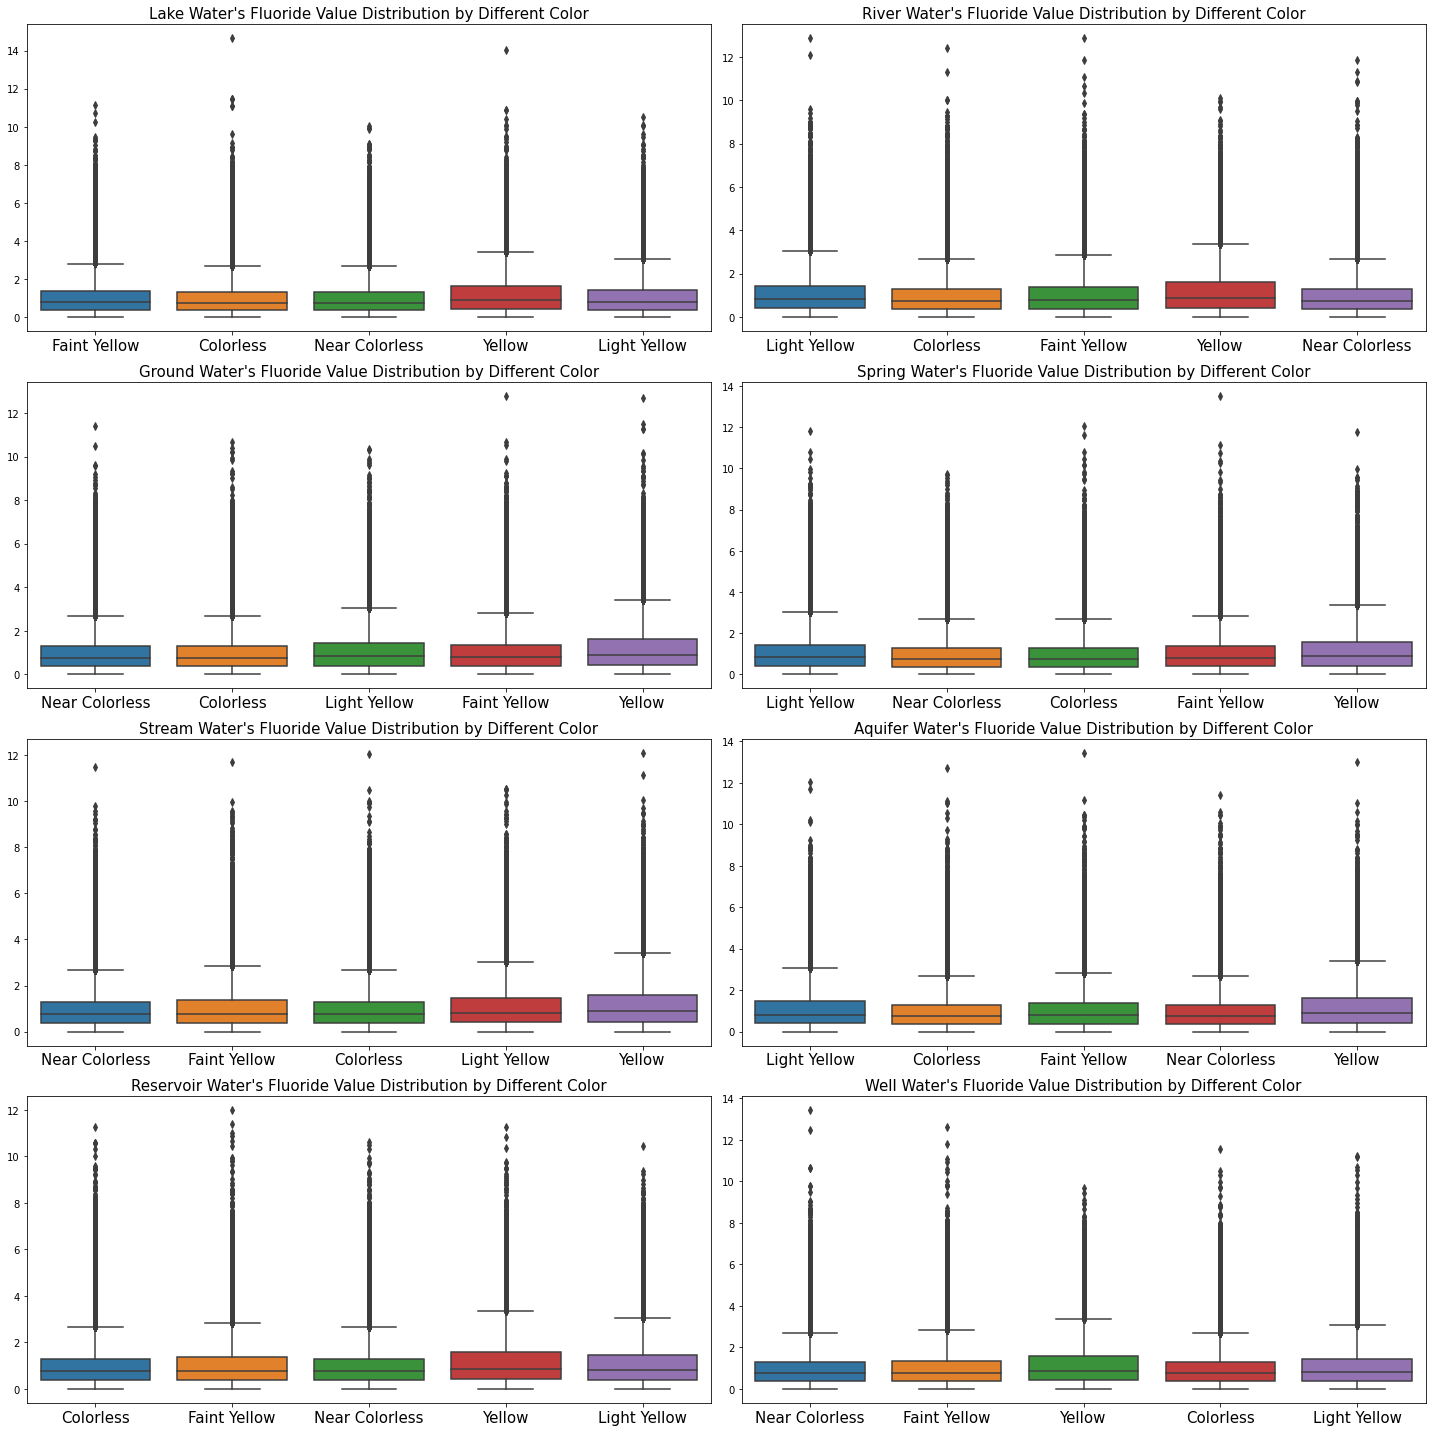

In [70]:
water_source_color_measure(data,'Fluoride');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on fluoride value.

### Let's see the water's fluoride value distribution by the target class.


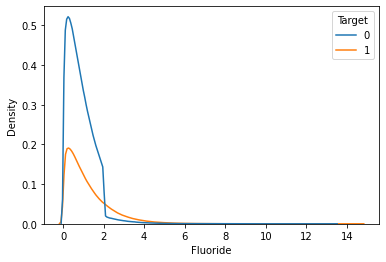

In [71]:
sns.kdeplot(x=data['Fluoride'],hue=data['Target']);

In [72]:
data.groupby('Target')['Fluoride'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4019428.0,0.864306,0.668707,0.000005,0.358296,0.733775,1.245831,13.421895
1,1748258.0,1.194630,1.067786,0.000012,0.420433,0.894279,1.652083,14.646254


#### The above plot and summary indicate the fluoride value is not alone sufficient for determining whether the water is drinkable or not. Although, the Fluoride value is an important indicator of water quality.

### Let's see the distribution of water's copper value(mg/L).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


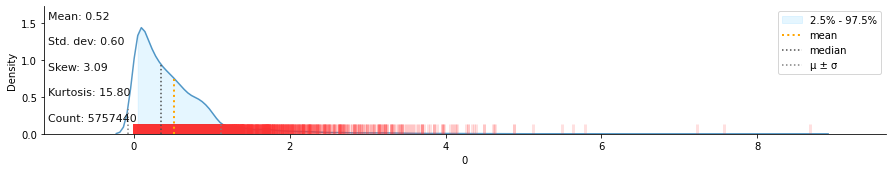

In [73]:
klib.dist_plot(data['Copper']);

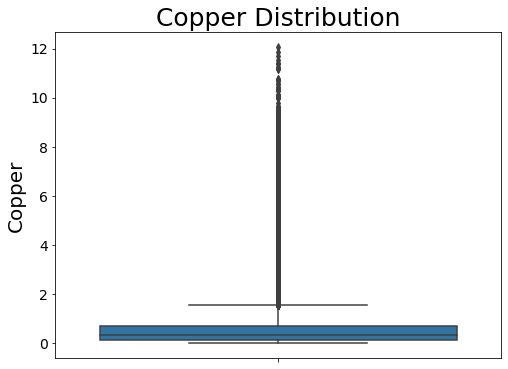

In [74]:
box_plot(data,'Copper',rot=90);

In [75]:
data['Copper'].describe()

count    5.757440e+06
mean     5.161216e-01
std      5.965534e-01
min      2.982735e-10
25%      1.288629e-01
50%      3.479592e-01
75%      7.010104e-01
max      1.207482e+01
Name: Copper, dtype: float64

#### The above histogram plot explain that the copper column is positively skewed.
#### Water's copper value ranges from 0.0 to 12.1.
#### The average copper value of water is 0.6
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water copper value distribution by comparing with the source of water and the color of the water.


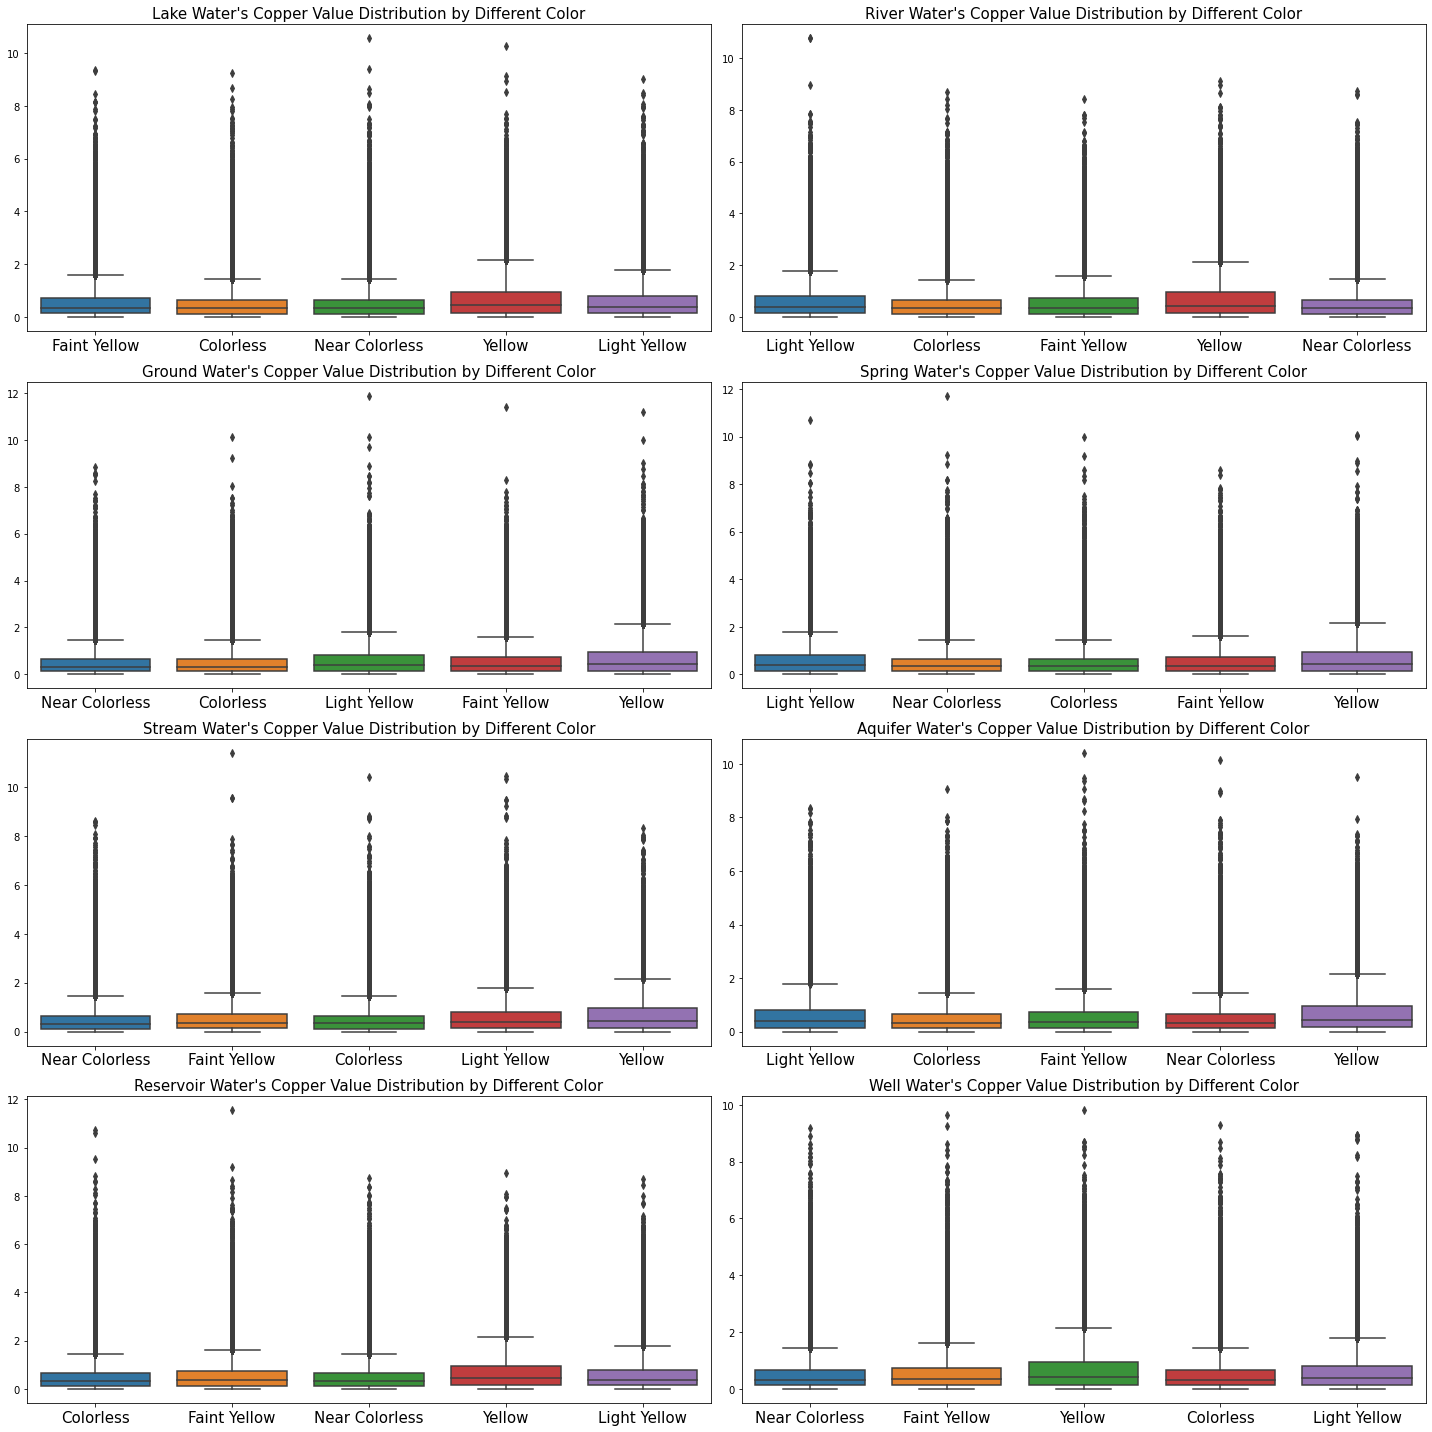

In [76]:
water_source_color_measure(data,'Copper');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on copper value.

### Let's see the water's copper value distribution by the target class.

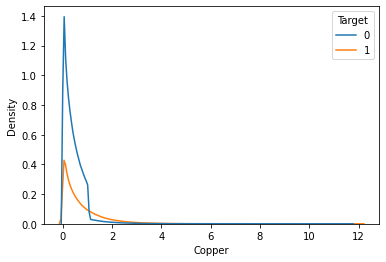

In [77]:
sns.kdeplot(x=data['Copper'],hue=data['Target']);

In [78]:
data.groupby('Target')['Copper'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4012550.0,0.423931,0.442320,2.982735e-10,0.118119,0.315023,0.618638,11.720259
1,1744890.0,0.728123,0.812311,7.388607e-09,0.161624,0.456137,1.012541,12.074816


#### The above plot and summary indicate the copper value is not alone sufficient for determining whether the water is drinkable or not. Although, the copper value is an important indicator of water quality.

### Let's see the distribution of water's Odor value(ou/m3).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


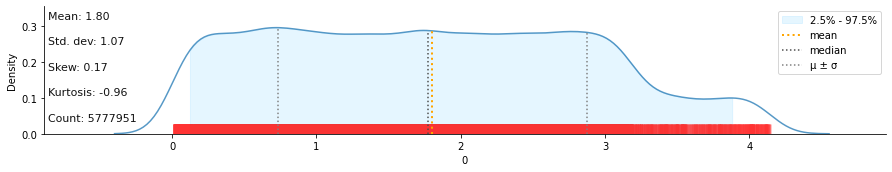

In [79]:
klib.dist_plot(data['Odor']);

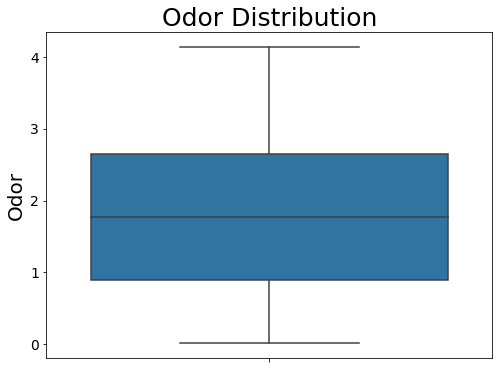

In [80]:

box_plot(data,'Odor',rot=90);

In [81]:
data['Odor'].describe()

count    5.777951e+06
mean     1.803459e+00
std      1.069586e+00
min      1.100007e-02
25%      8.921019e-01
50%      1.774284e+00
75%      2.654286e+00
max      4.141998e+00
Name: Odor, dtype: float64

#### The above histogram plot explain that the odor column is normally distributed.
#### Water's odor value ranges from  0.01 to 4.142.
#### The average odor value of water is 1.8035.
#### The boxplot explains that there are no outliers.

### Let's see if is there any change in water odor value distribution by comparing with the source of water and the color of the water.

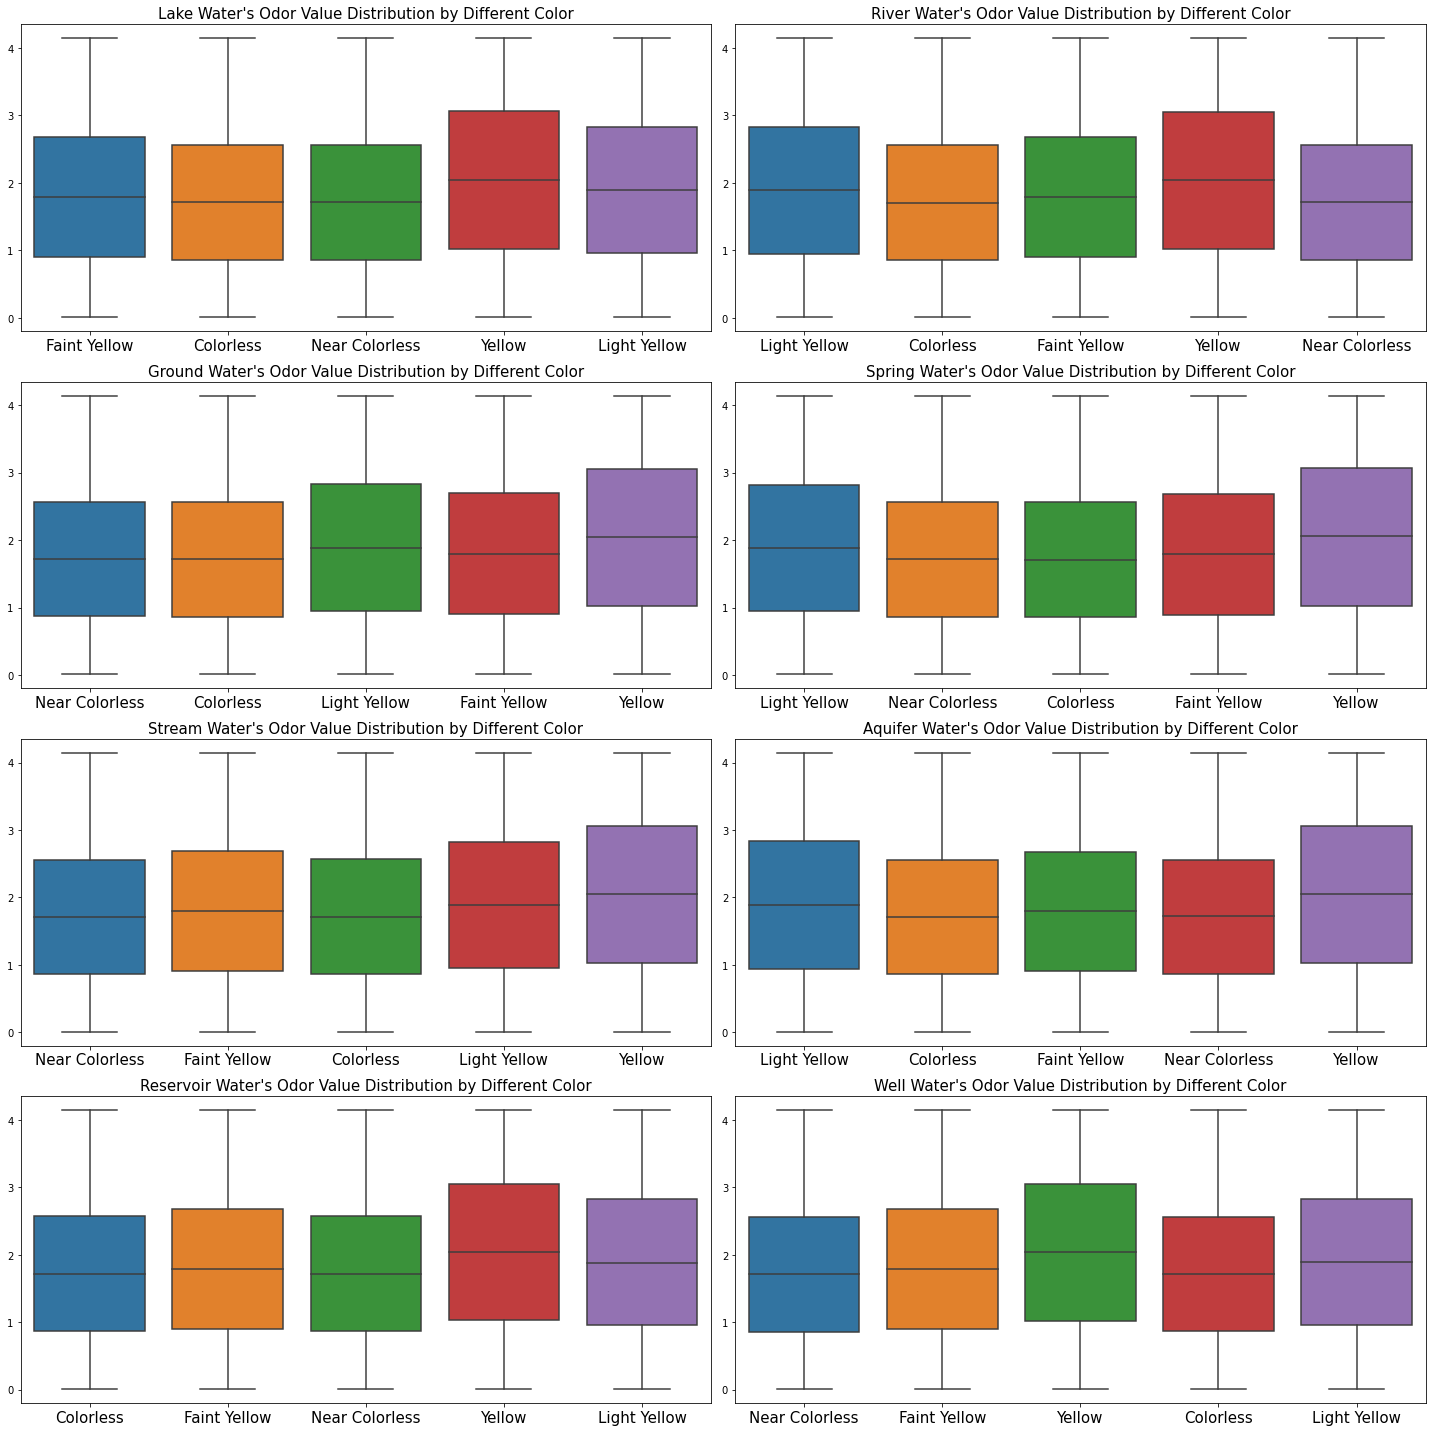

In [82]:
water_source_color_measure(data,'Odor');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on odor value.

### Let's see the water's odor value distribution by the target class.

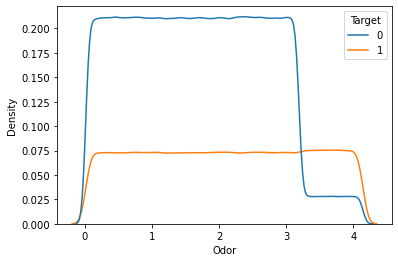

In [83]:
sns.kdeplot(x=data['Odor'],hue=data['Target']);

In [84]:
data.groupby('Target')['Odor'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4026568.0,1.679802,0.984671,0.011,0.837017,1.664547,2.490215,4.141994
1,1751383.0,2.087758,1.195439,0.011,1.051015,2.091435,3.129724,4.141998


#### The above plot and summary indicate the odor value is not a sufficient indicator for determining whether the water is drinkable or not.

### Let's see the distribution of water's sulfate value(mg/l).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


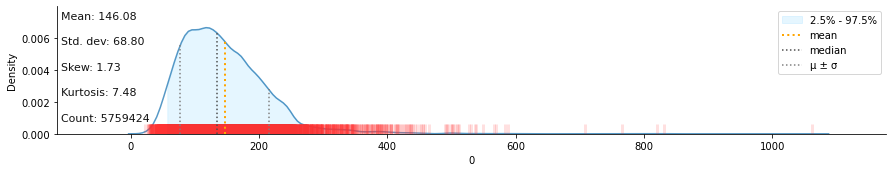

In [85]:
klib.dist_plot(data['Sulfate']);

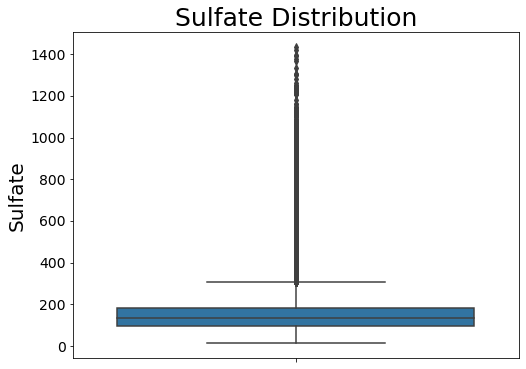

In [86]:
box_plot(data,'Sulfate',rot=90);

In [87]:
data['Sulfate'].describe()

count    5.759424e+06
mean     1.460764e+02
std      6.879844e+01
min      1.194073e+01
25%      9.777114e+01
50%      1.346489e+02
75%      1.817703e+02
max      1.434587e+03
Name: Sulfate, dtype: float64

#### The above histogram plot explain that the sulafate column is positively skewed.
#### Water's sulafate value ranges from 11.941 to 1434.6.
#### The average sulafate value of water is 146.1.
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water sulfate value distribution by comparing with the source of water and the color of the water.


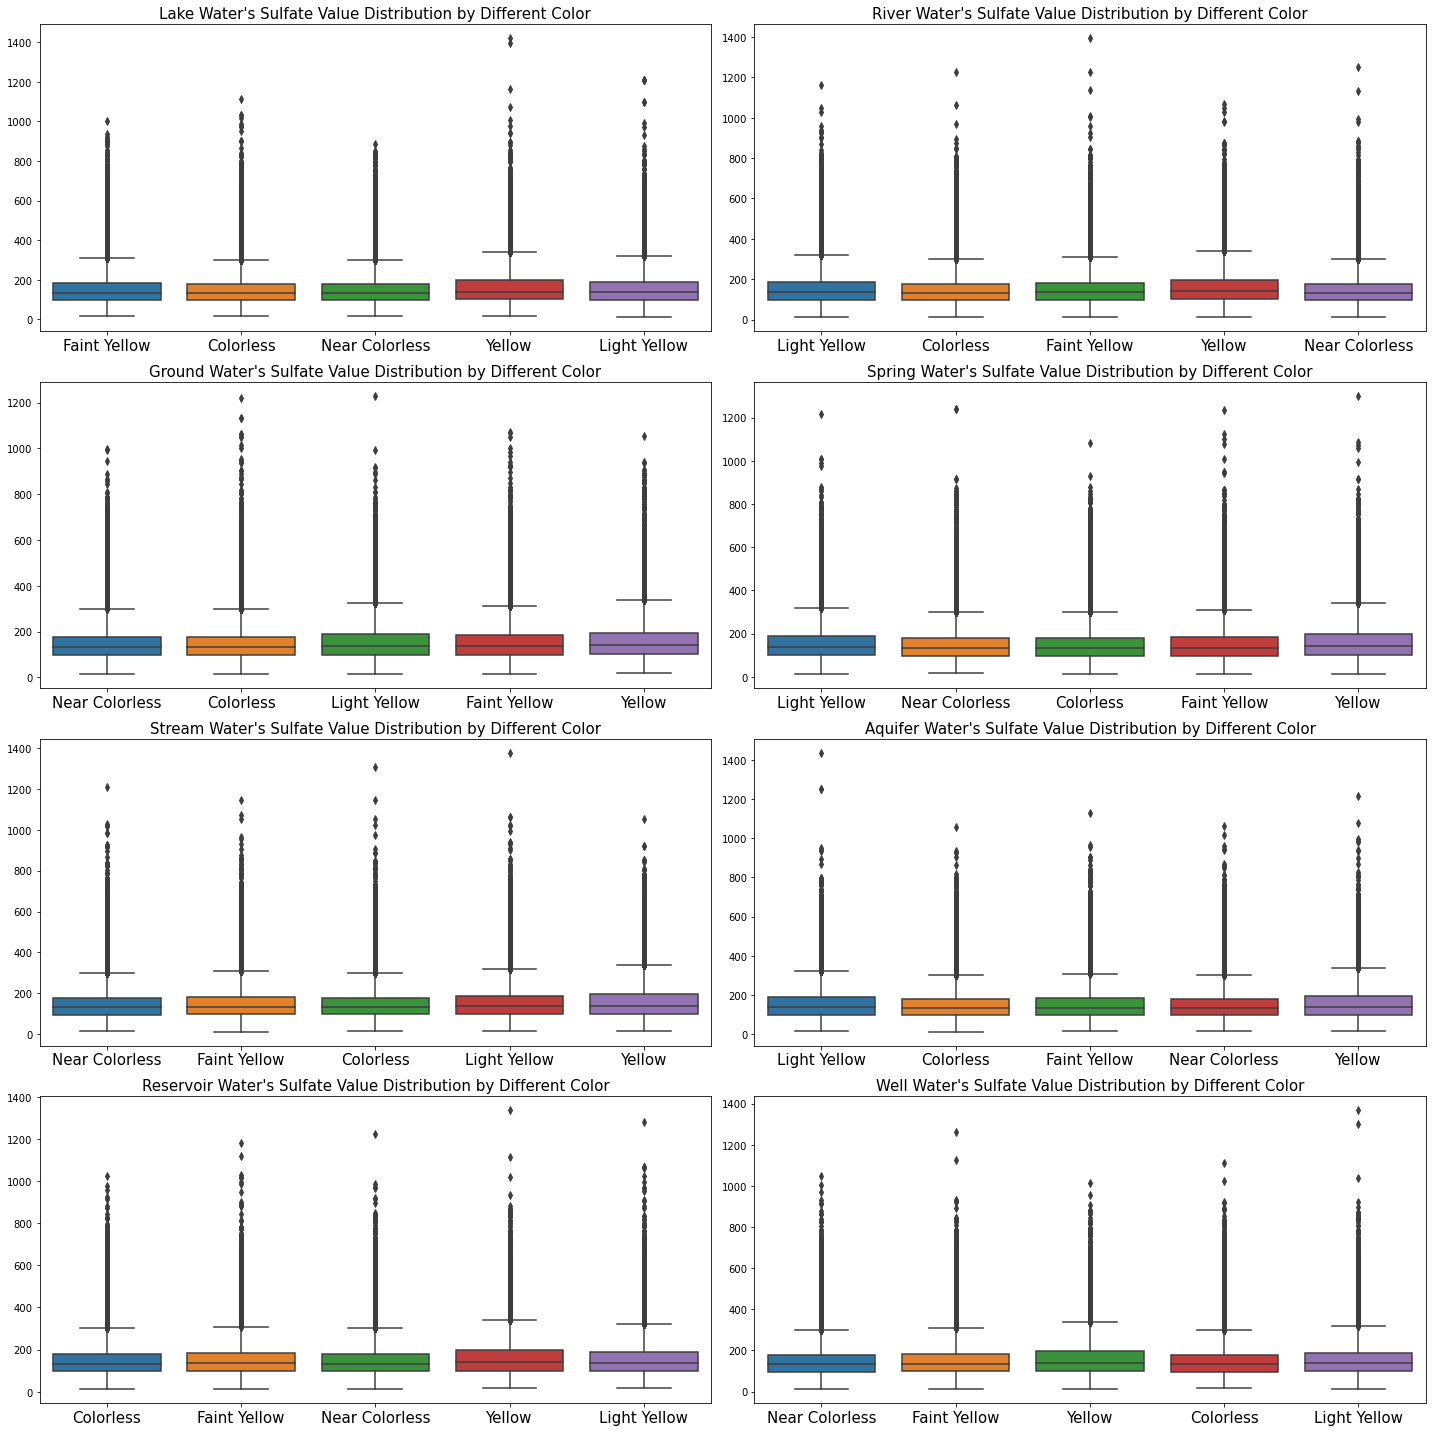

In [88]:
water_source_color_measure(data,'Sulfate');


#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on sulfate value.


### Let's see the water's sulfate value distribution by the target class.


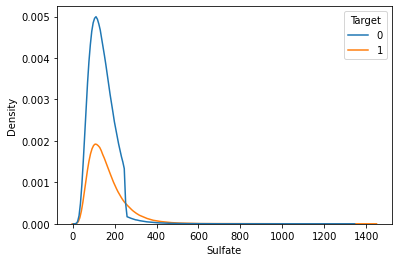

In [89]:
sns.kdeplot(x=data['Sulfate'],hue=data['Target']);

In [90]:
data.groupby('Target')['Sulfate'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4013843.0,139.778585,58.849167,11.940727,96.519338,132.067354,176.031114,1335.991151
1,1745581.0,160.557931,85.747270,12.198765,100.922374,141.476982,198.562293,1434.586543


#### The above plot and summary indicate the sulfate value is not a sufficient factor for determining  whether the water is drinkable or not.

### Let's see the distribution of water's conductivity value(µmhos/cm).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


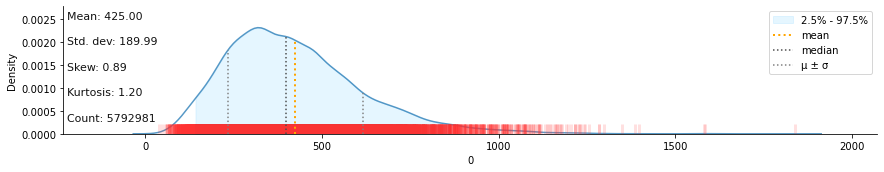

In [91]:
klib.dist_plot(data['Conductivity']);

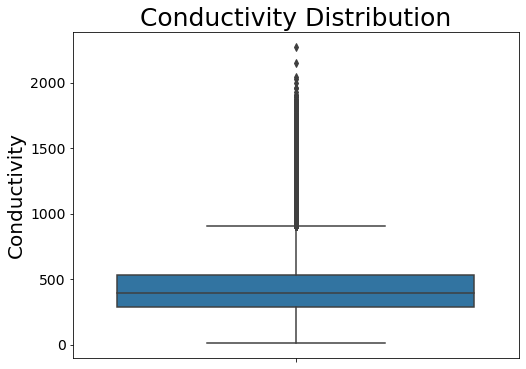

In [92]:
box_plot(data,'Conductivity',rot=90);

In [93]:

data['Conductivity'].describe()

count    5.792981e+06
mean     4.249974e+02
std      1.899937e+02
min      1.059998e+01
25%      2.864261e+02
50%      3.970808e+02
75%      5.333489e+02
max      2.271632e+03
Name: Conductivity, dtype: float64

#### The above histogram plot explain that the conductivity column is slightly positive skewed.
#### Water's conductivity value ranges from 10.6 to 2271.6
#### The average conductivity value of water is 424.997.
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water conductivity value distribution by comparing with the source of water and the color of the water.

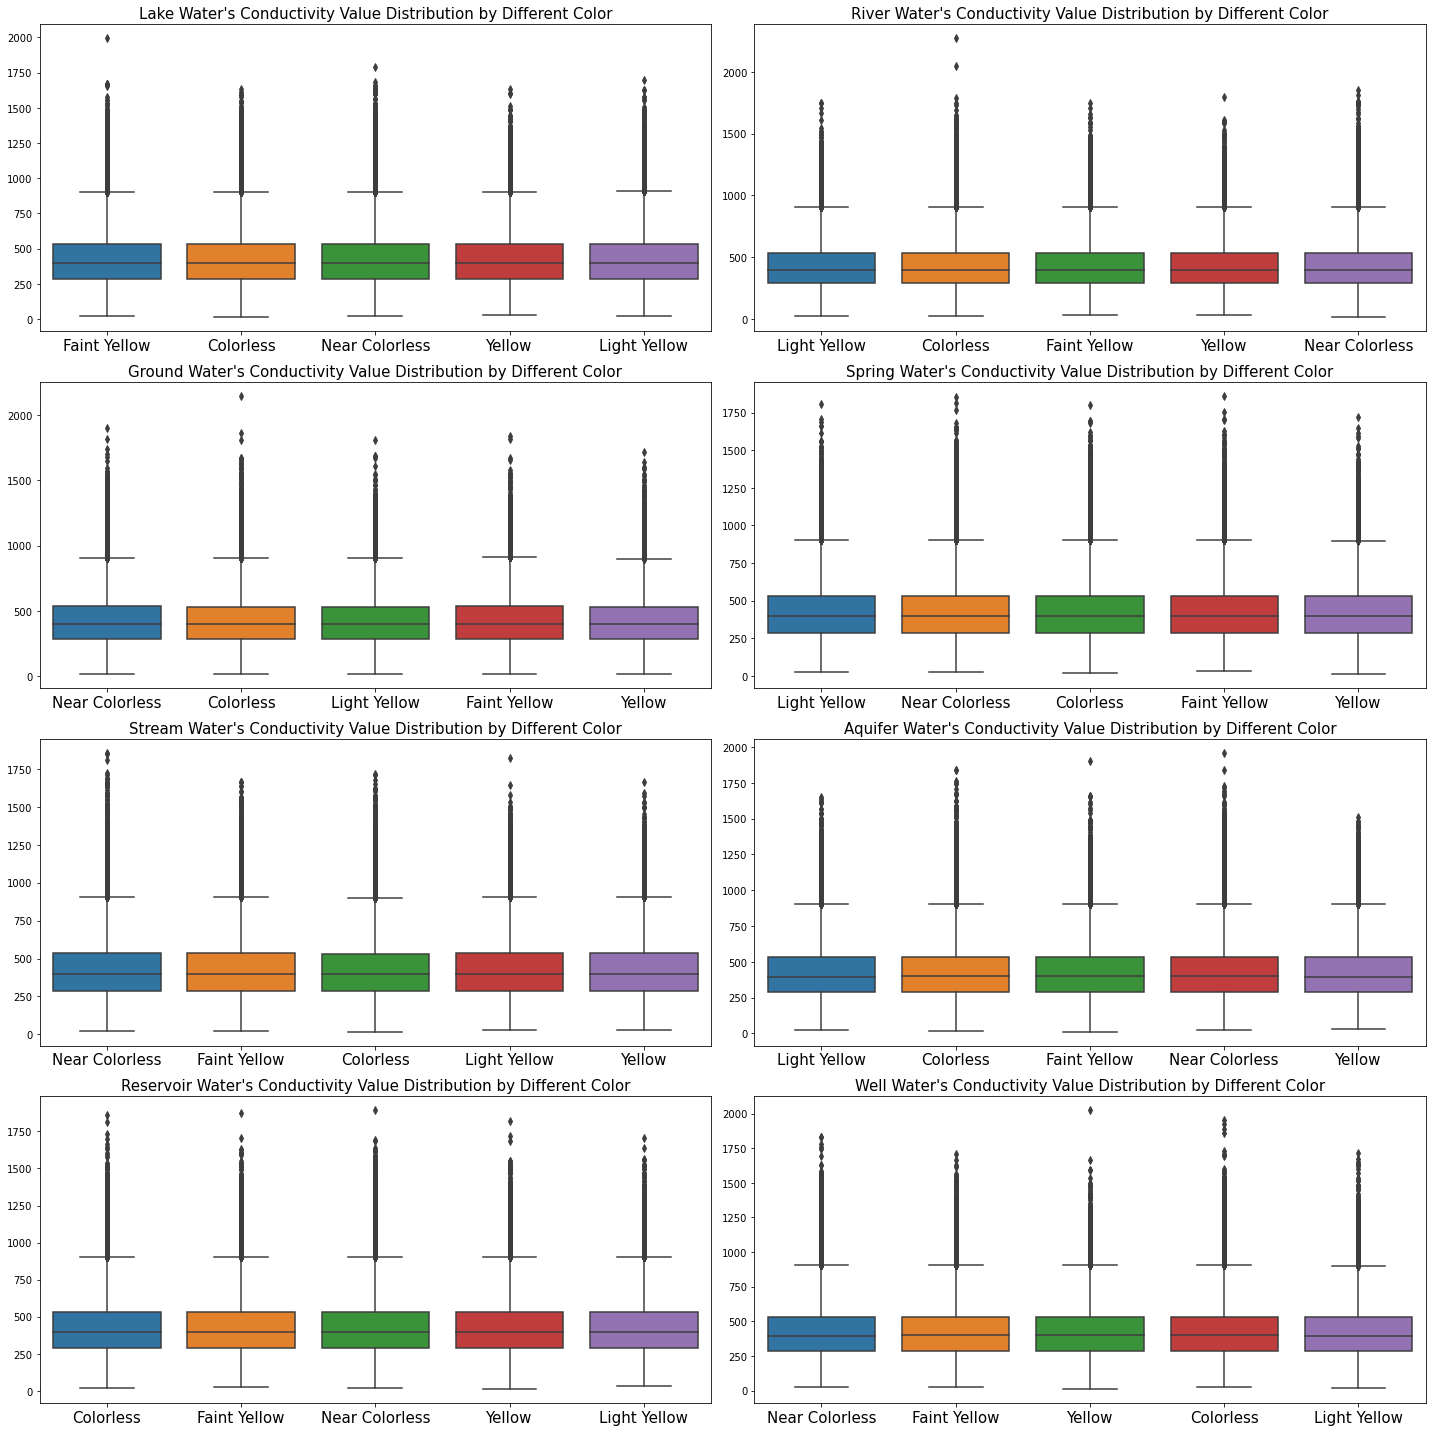

In [94]:
water_source_color_measure(data,'Conductivity');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on conductivity value.


### Let's see the water's conductivity value distribution by the target class.

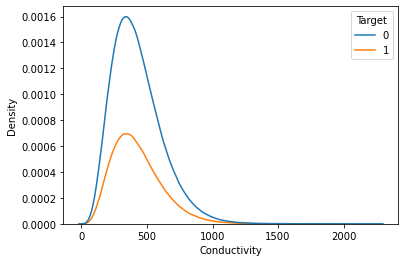

In [95]:
sns.kdeplot(x=data['Conductivity'],hue=data['Target']);

In [96]:
data.groupby('Target')['Conductivity'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4037262.0,424.996548,190.006383,12.538804,286.397187,397.141235,533.394851,2271.631722
1,1755719.0,424.999472,189.964517,10.599984,286.491067,396.937701,533.249772,1993.114444


#### The above plot and summary indicate the conductivity value is not alone sufficient for determining whether the water is drinkable or not. Although, the conductivity value is an important indicator of water quality.

### Let's see the distribution of water's chlorine value(mg/L).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


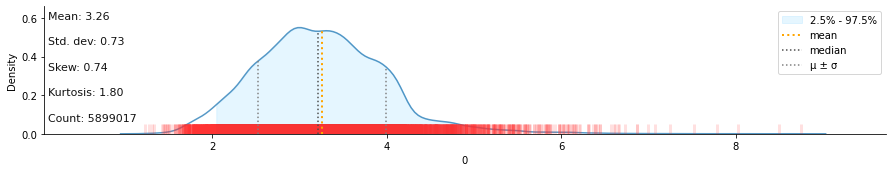

In [97]:
klib.dist_plot(data['Chlorine']);

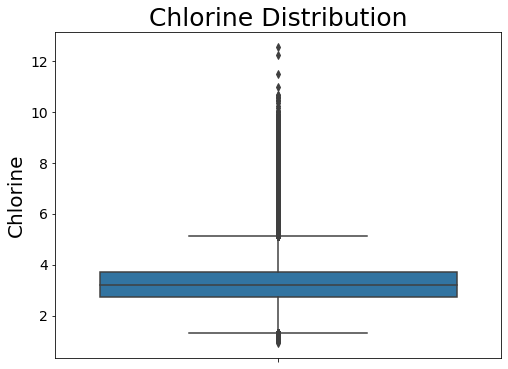

In [98]:
box_plot(data,'Chlorine',rot=90);

In [99]:
data['Chlorine'].describe()

count    5.899017e+06
mean     3.255738e+00
std      7.328441e-01
min      9.019921e-01
25%      2.744504e+00
50%      3.209748e+00
75%      3.705217e+00
max      1.256663e+01
Name: Chlorine, dtype: float64

#### The above histogram plot explain that the chlorine column is slightly positive skewed.
#### Water's chlorine value ranges from 0.902 to 11.26.
#### The average chlorine value of water is 3.26.
#### The boxplot explains that there are outliers above the third quartile and below the first quartile.

### Let's see if is there any change in water chlorine value distribution by comparing with the source of water and the color of the water.

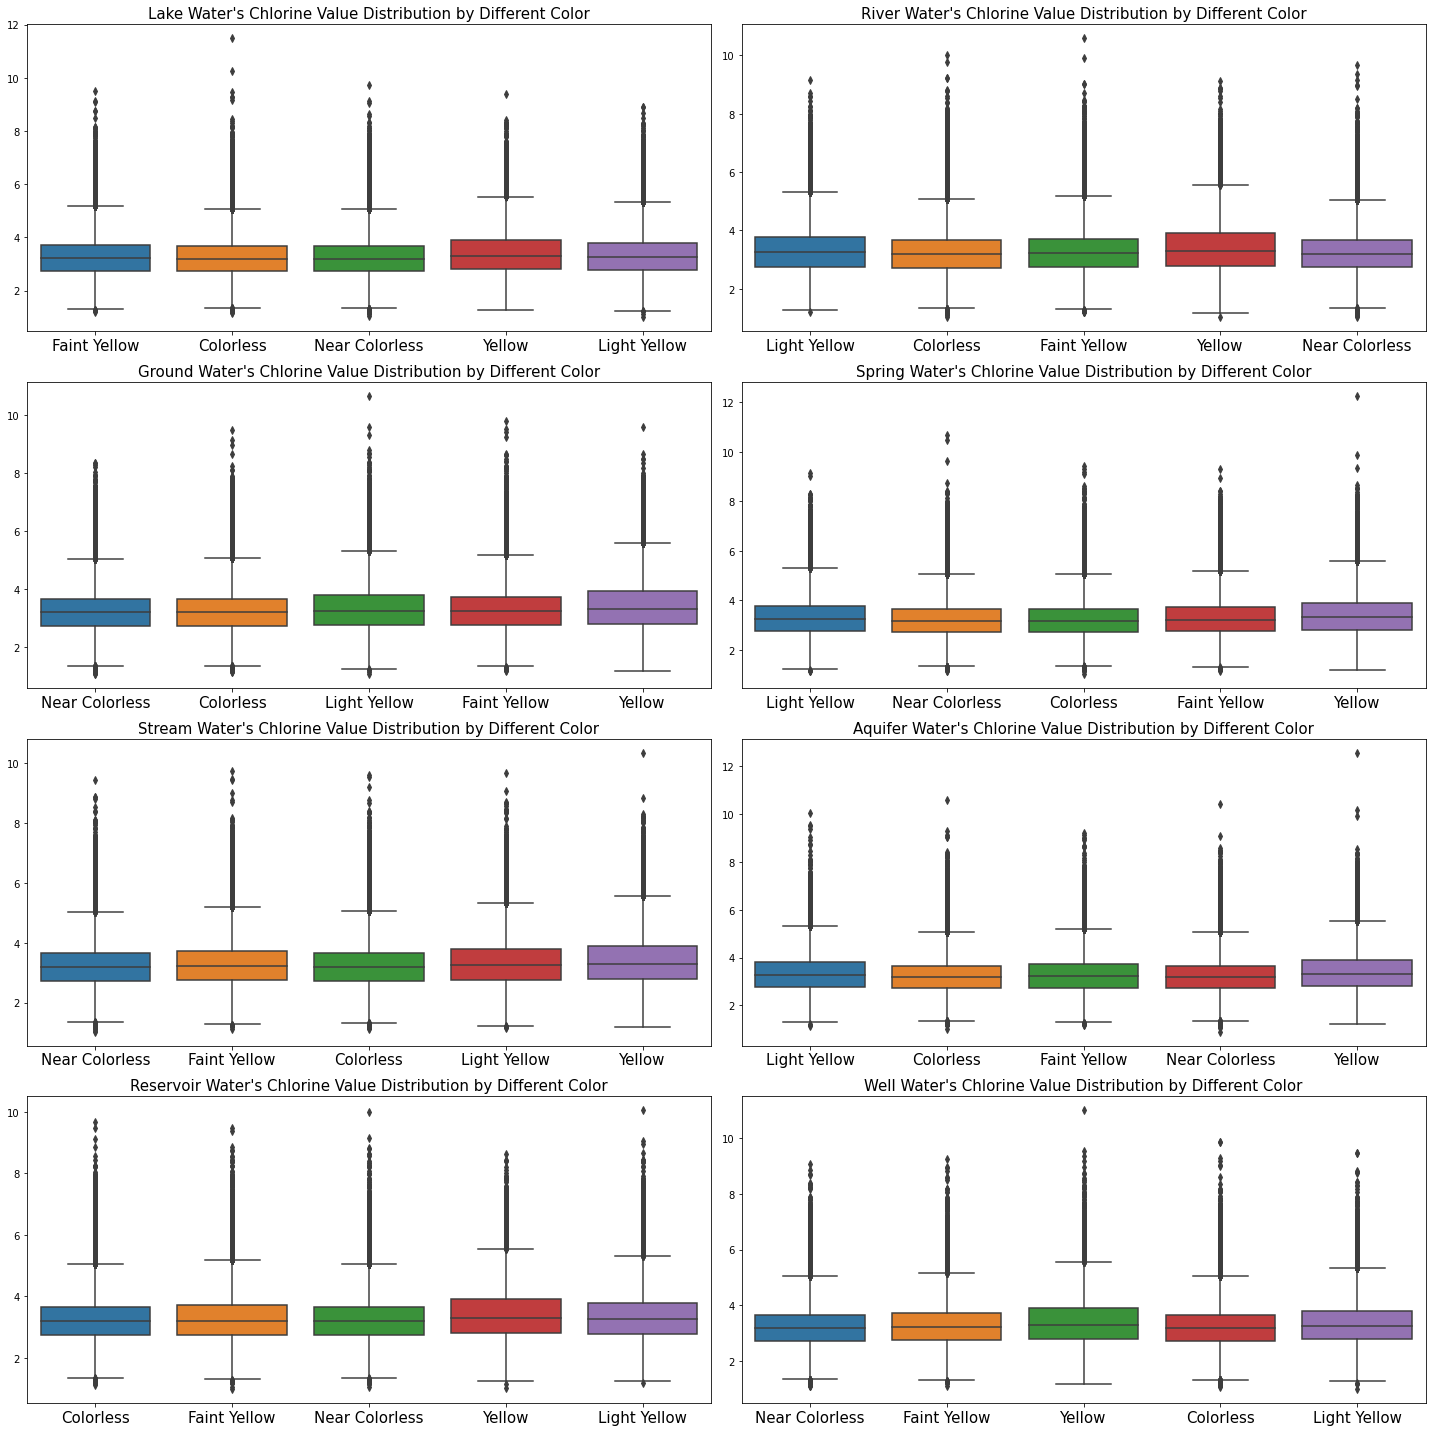

In [100]:
water_source_color_measure(data,'Chlorine');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on Chlorine value.


### Let's see the water's chlorine value distribution by the target class.

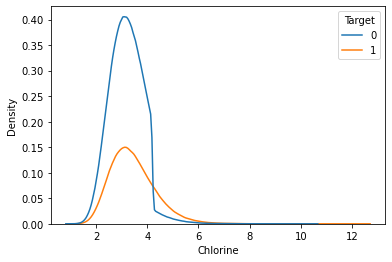

In [101]:
sns.kdeplot(x=data['Chlorine'],hue=data['Target']);

In [102]:
data.groupby('Target')['Chlorine'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4111330.0,3.178691,0.646811,0.901992,2.720348,3.168040,3.627823,10.575774
1,1787687.0,3.432930,0.874637,0.993754,2.807464,3.324878,3.943049,12.566630


#### The above plot and summary indicate the chlorine value is not alone sufficient for determining whether the water is drinkable or not. Although, the chlorine value is an important indicator of water quality.

### Let's see the distribution of water's manganese value(mg/L).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


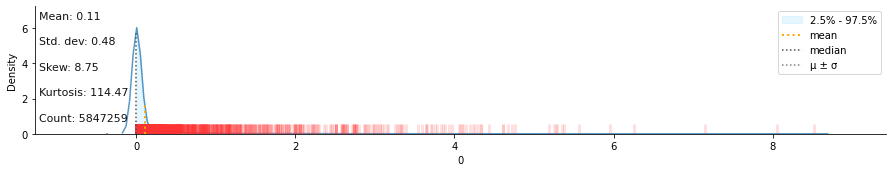

In [103]:
klib.dist_plot(data['Manganese']);

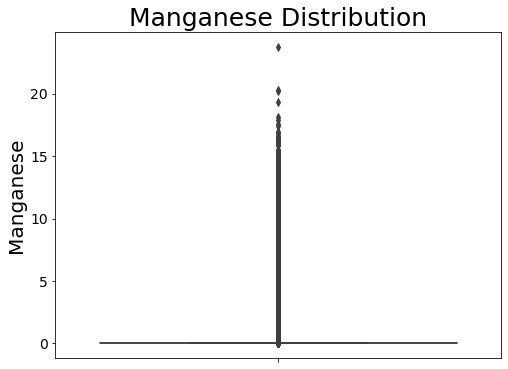

In [104]:
box_plot(data,'Manganese',rot=90);

In [105]:
data['Manganese'].describe()

count    5.847259e+06
mean     1.092802e-01
std      4.761827e-01
min      4.793505e-55
25%      2.522376e-06
50%      6.481943e-04
75%      1.672082e-02
max      2.374086e+01
Name: Manganese, dtype: float64


#### The above histogram plot explain that the manganese column is highly positive skewed.
#### Water's manganese value ranges from 0.0 to 23.741.
#### The average manganese value of water is 0.1093.
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water manganese value distribution by comparing with the source of water and the color of the water.

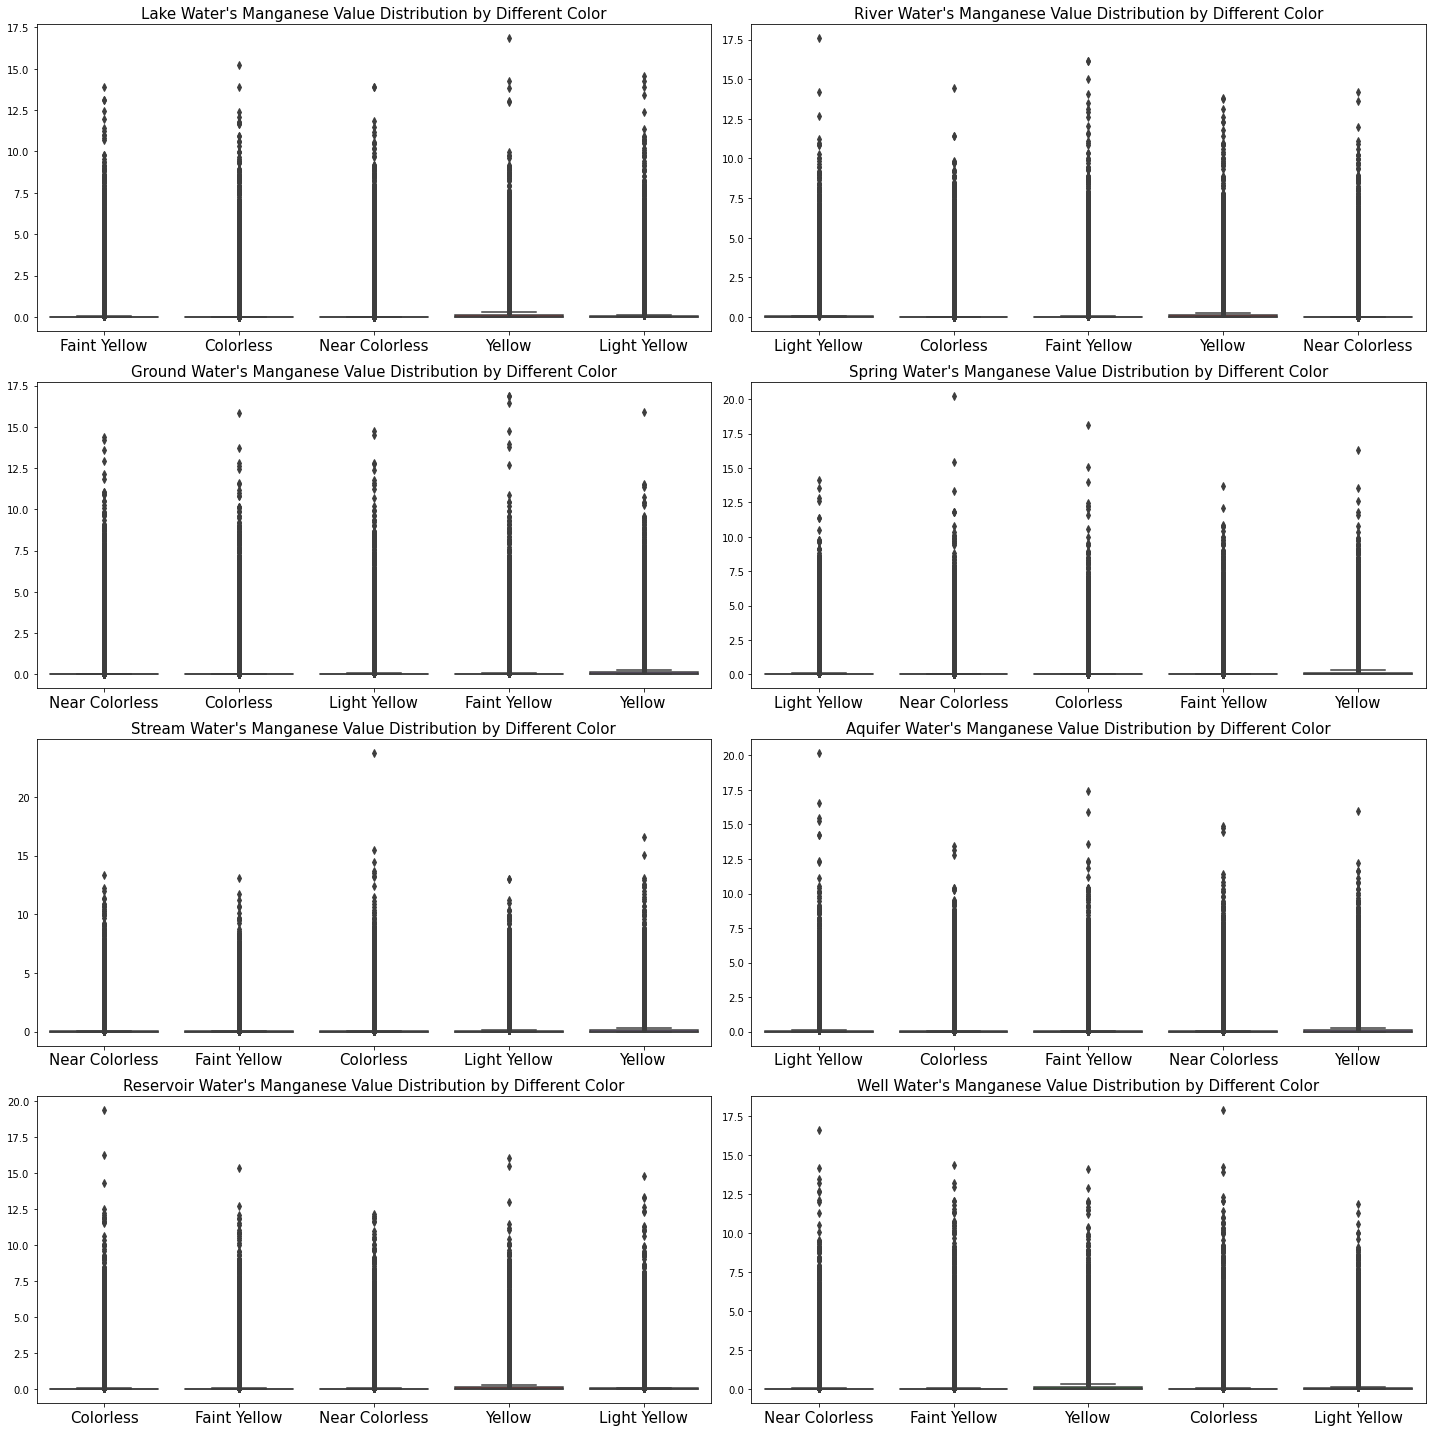

In [106]:
water_source_color_measure(data,'Manganese');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on manganese value.

### Let's see the water's manganese value distribution by the target class.

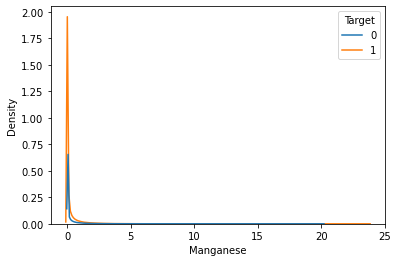

In [107]:
sns.kdeplot(x=data['Manganese'],hue=data['Target']);

In [108]:
data.groupby('Target')['Manganese'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4075062.0,0.045636,0.301435,4.793505e-55,0.000001,0.000301,0.007740,20.181264
1,1772197.0,0.255627,0.713080,1.214196e-54,0.000021,0.005328,0.140401,23.740860


#### The above plot and summary indicate the manganese value is not alone sufficient for determining whether the water is drinkable or not. Although, the manganese value is an important indicator of water quality.

### Let's see the distribution of water's total dissolved solids value(milligrams per liter).


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


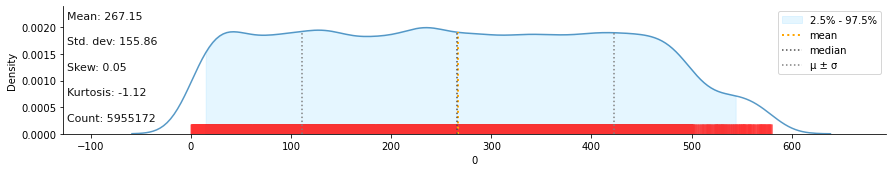

In [109]:
klib.dist_plot(data['Total Dissolved Solids']);

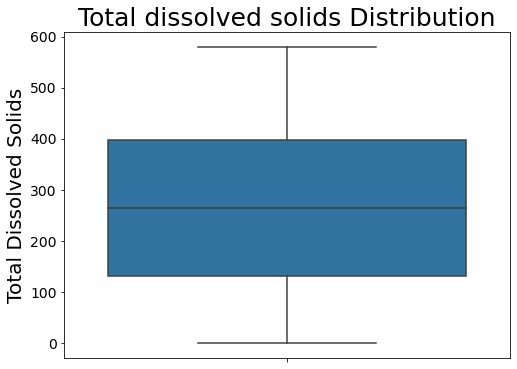

In [110]:
box_plot(data,'Total Dissolved Solids',rot=90);

In [111]:
data['Total Dissolved Solids'].describe()

count    5.955172e+06
mean     2.671454e+02
std      1.558586e+02
min      1.048902e-02
25%      1.329157e+02
50%      2.658880e+02
75%      3.984954e+02
max      5.797999e+02
Name: Total Dissolved Solids, dtype: float64


#### The above histogram plot explain that the total dissolved solids column is normally distributed.
#### Water's total dissolved solids value ranges from 0.0105 to 579.8.
#### The average total dissolved solids value of water is 267.15.
#### The boxplot explains that there are no outliers.


### Let's see if is there any change in water total dissolved solids value distribution by comparing with the source of water and the color of the water.


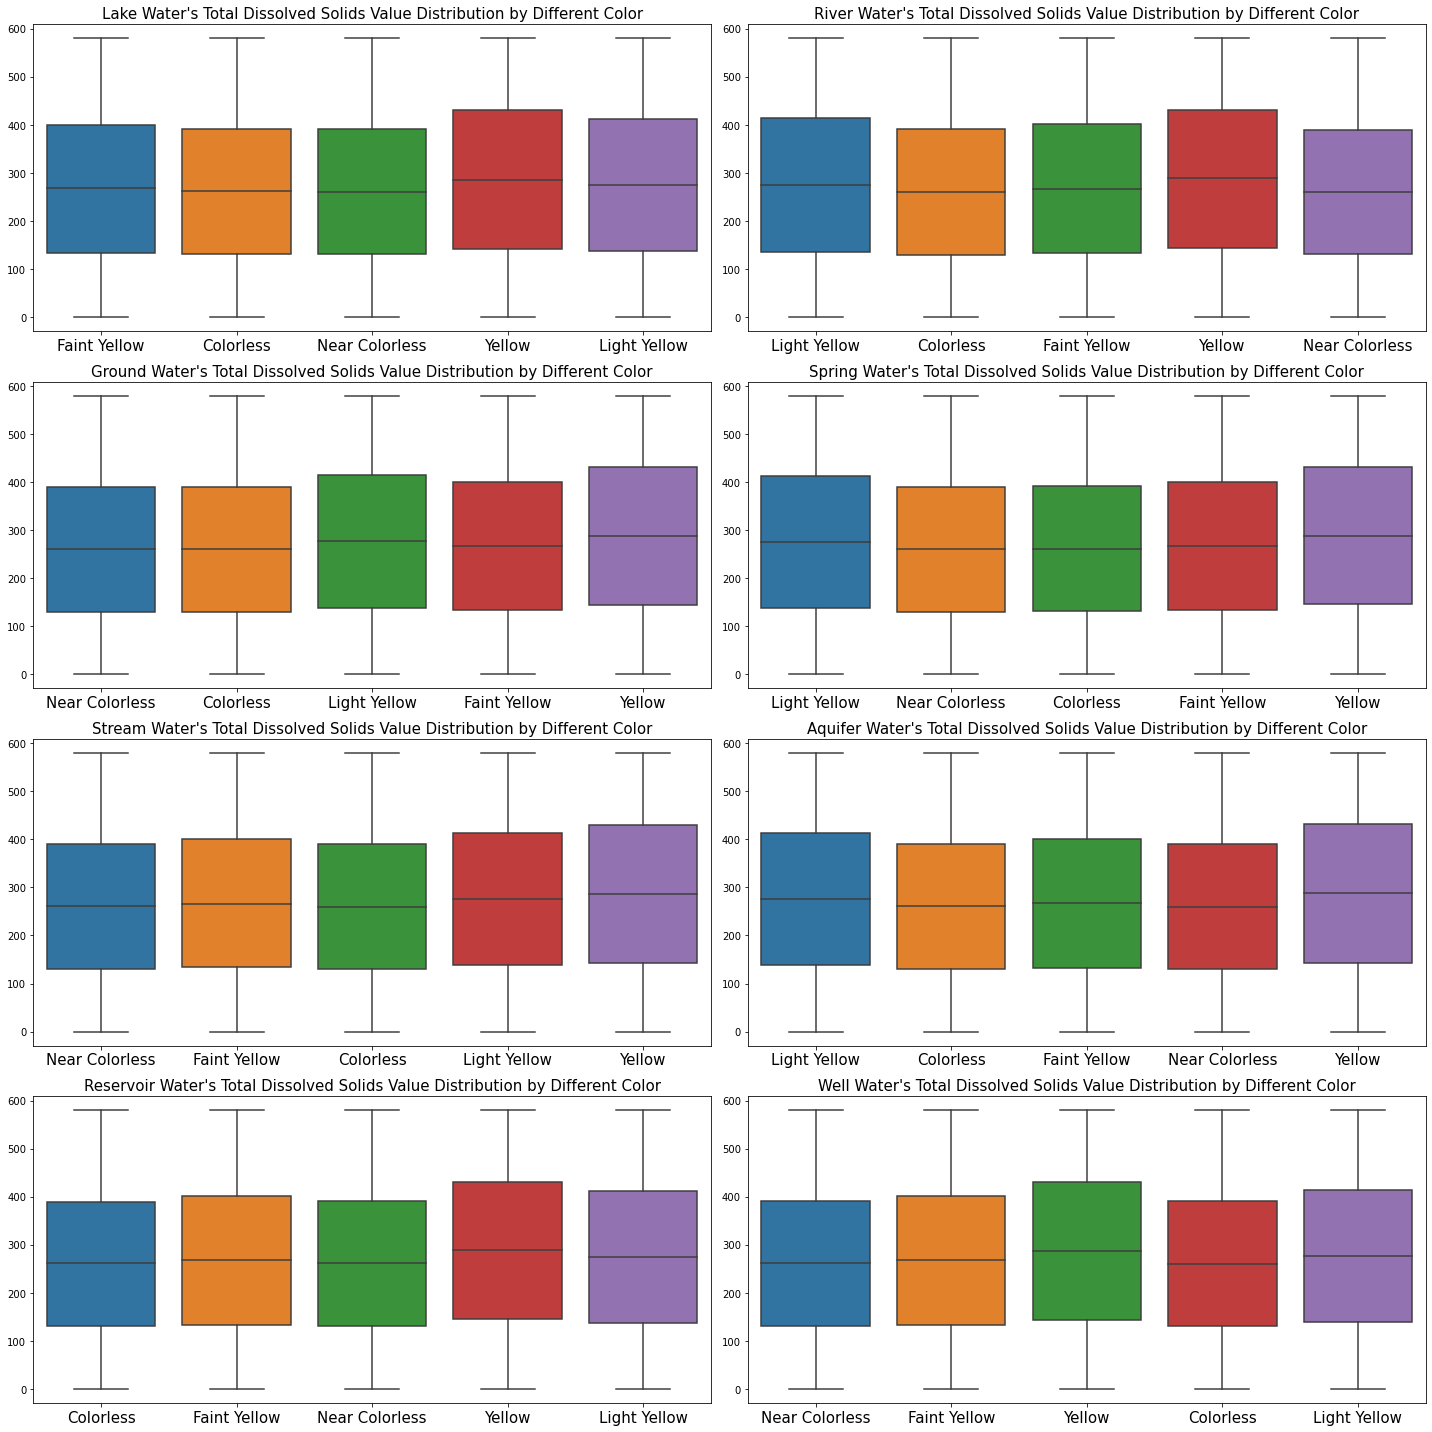

In [112]:

water_source_color_measure(data,'Total Dissolved Solids');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on total dissolved solids value.

### Let's see the water's total dissolved solids value value distribution by the target class.

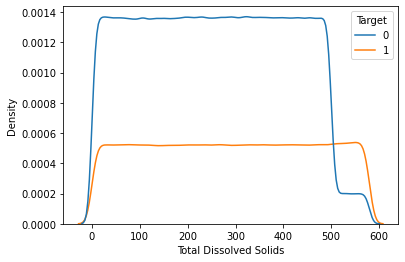

In [113]:
sns.kdeplot(x=data['Total Dissolved Solids'],hue=data['Target']);


In [114]:

data.groupby('Target')['Total Dissolved Solids'].describe()


,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4150381.0,256.844884,149.187090,0.010529,128.175401,256.206515,383.944110,579.799928
1,1804791.0,290.832853,167.829801,0.010489,145.365954,291.083251,436.431116,579.799623


#### The above plot and summary indicate the total dissolved solids value is not alone sufficient for determining whether the water is drinkable or not. Although, the total dissolved solids value is not used as a sole indicator to determine water quality.Instead, a combination of TDS value and other measures like pH value will be considered.

### Let's see the distribution of water's temperature value(c).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


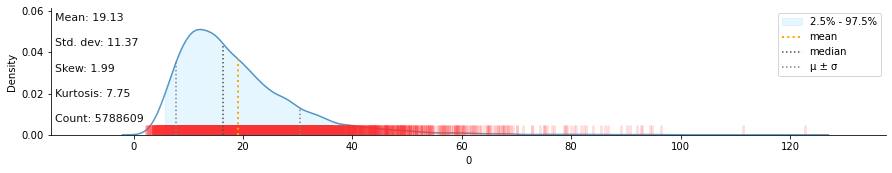

In [115]:
klib.dist_plot(data['Water Temperature']);

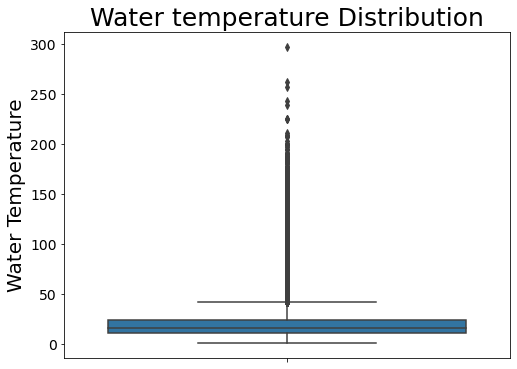

In [116]:
box_plot(data,'Water Temperature',rot=90);

In [117]:
data['Water Temperature'].describe()

count    5.788609e+06
mean     1.912982e+01
std      1.136623e+01
min      6.661938e-01
25%      1.134879e+01
50%      1.644428e+01
75%      2.383543e+01
max      2.973086e+02
Name: Water Temperature, dtype: float64

#### The above histogram plot explain that the temperature column is positively skewed.
#### Water's temperature value ranges from 0.067 to 297.31.
#### The average temperature value of water is 19.13.
#### The boxplot explains that there are outliers above the third quartile.

### Let's see if is there any change in water temperature value distribution by comparing with the source of water and the color of the water.

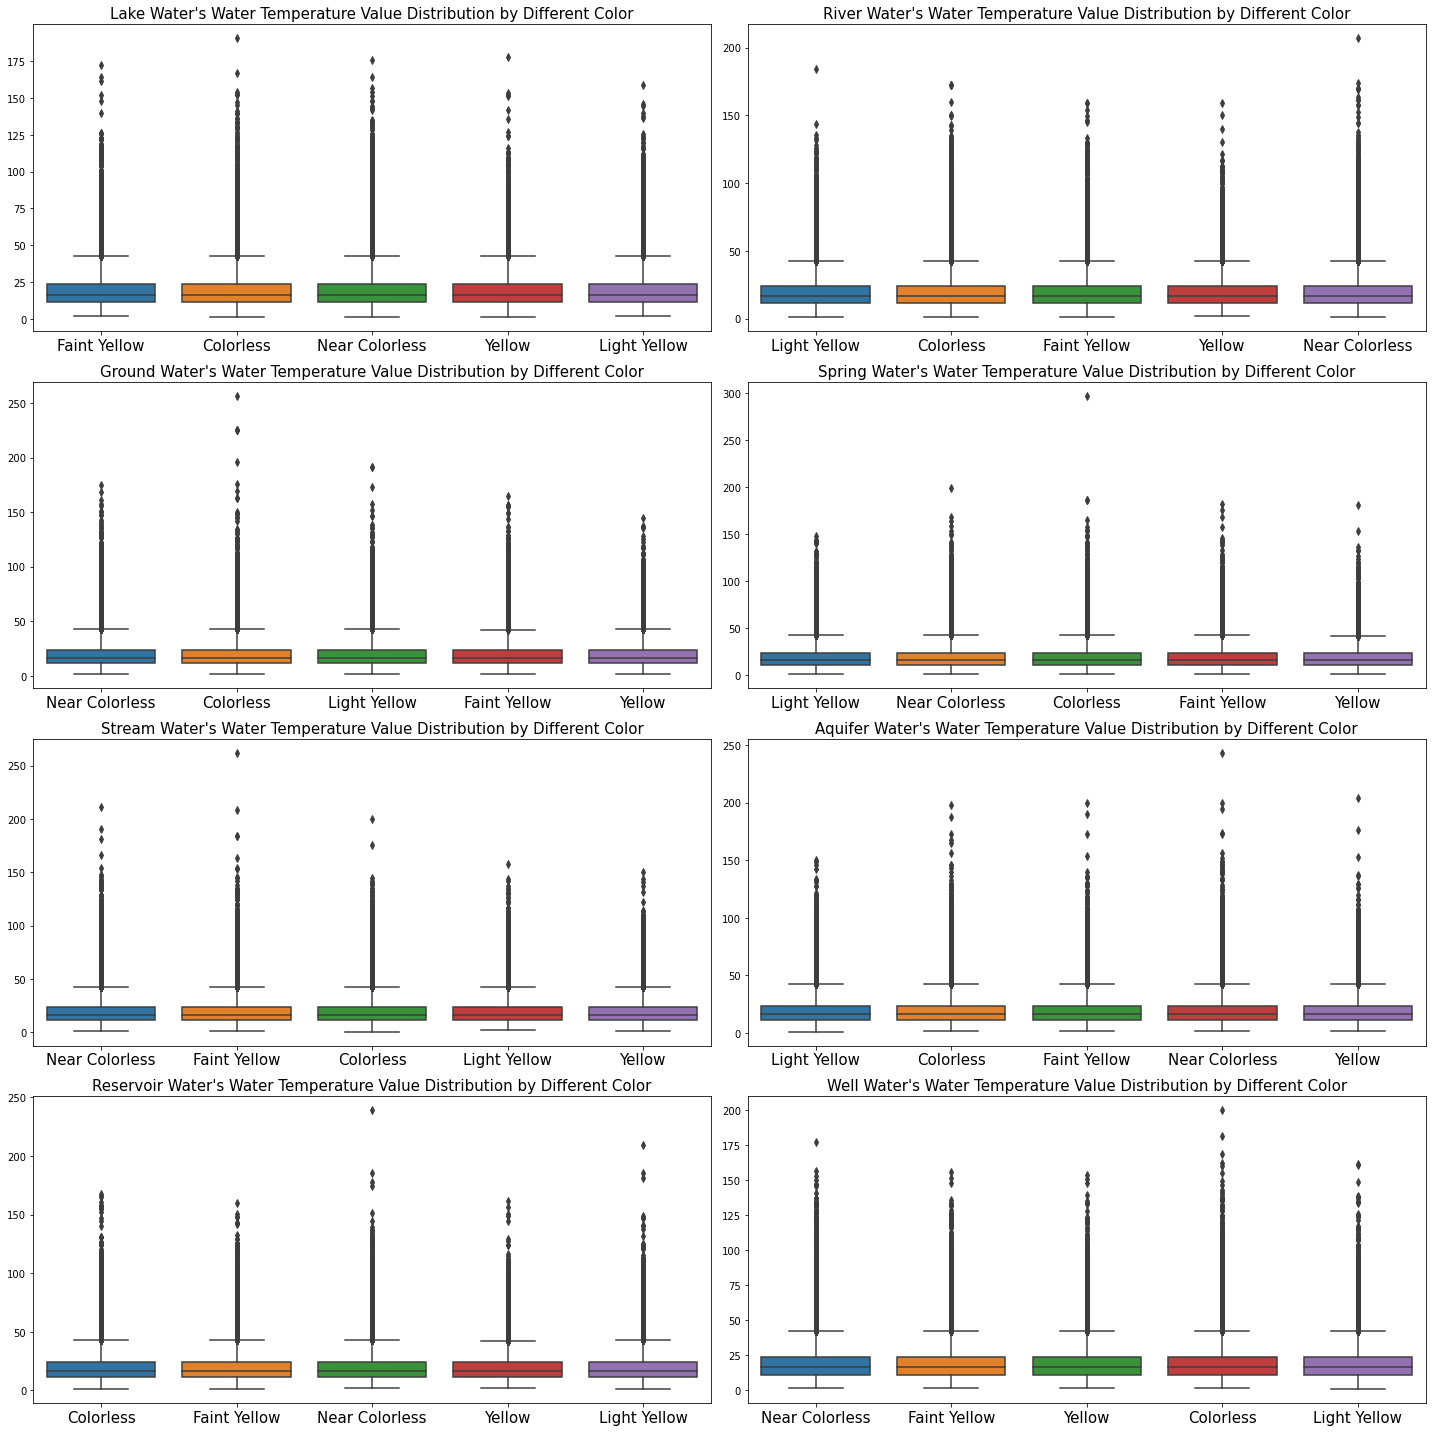

In [118]:
water_source_color_measure(data,'Water Temperature');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on temperature value.

### Let's see the water's temperature value distribution by the target class.

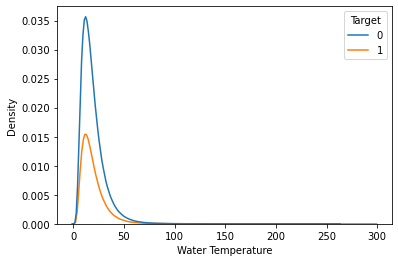

In [119]:
sns.kdeplot(x=data['Water Temperature'],hue=data['Target']);

In [120]:
data.groupby('Target')['Water Temperature'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4034516.0,19.130224,11.372635,0.666194,11.346034,16.442553,23.834535,261.797676
1,1754093.0,19.128883,11.351481,1.373109,11.355059,16.448130,23.837792,297.308629


#### The above plot and summary indicate the temperature value is not determining whether the water is drinkable or not.

### Let's see the distribution of water's air temperature value(c).

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


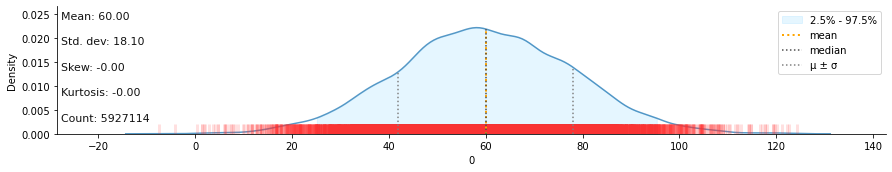

In [121]:
klib.dist_plot(data['Air Temperature']);

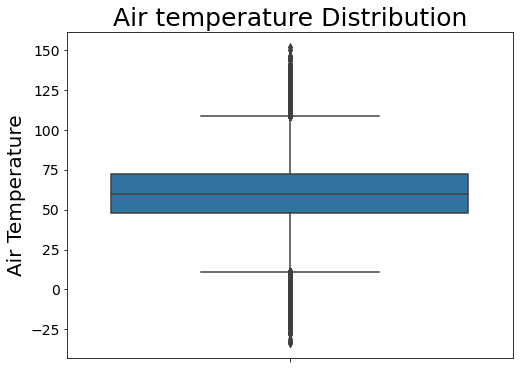

In [122]:
box_plot(data,'Air Temperature',rot=90);

In [123]:
data['Air Temperature'].describe()

count    5.927114e+06
mean     6.000324e+01
std      1.809977e+01
min     -3.387091e+01
25%      4.779120e+01
50%      5.999681e+01
75%      7.221235e+01
max      1.521237e+02
Name: Air Temperature, dtype: float64

#### The above histogram plot explain that the air temperature column is normally distributed.
#### Water's air temperature value ranges from -33.8 to 152.124.
#### The average air temperature value of water is 60.00324.
#### The boxplot explains that there are outliers above the third quartile brlow the first quartile.

### Let's see if is there any change in water's air temperature value distribution by comparing with the source of water and the color of the water.

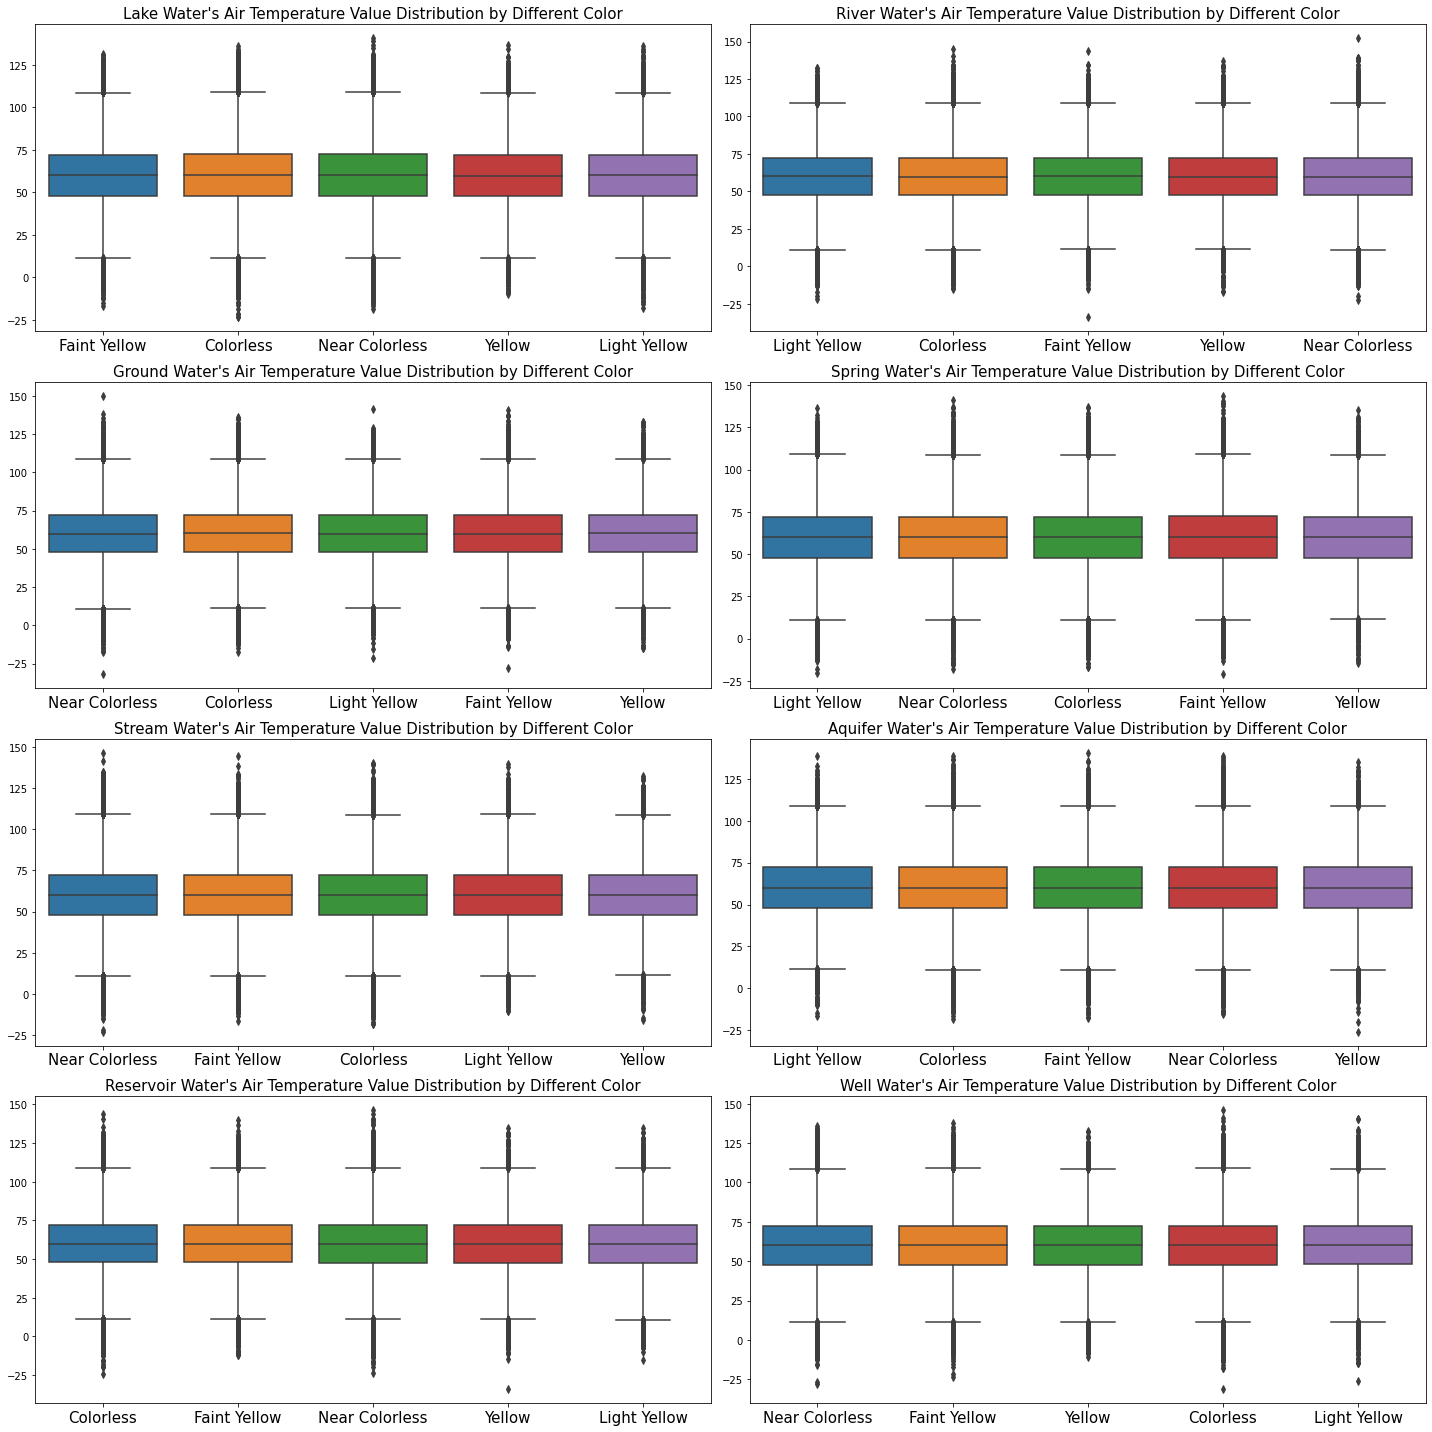

In [124]:
water_source_color_measure(data,'Air Temperature');

#### The above plot explains that there is no significant interaction effect between the color of the water and the water source on air temperature value.

### Let's see the water's air temperature value distribution by the target class.

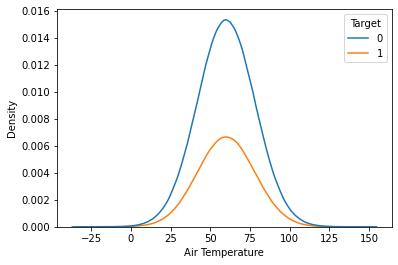

In [125]:
sns.kdeplot(x=data['Air Temperature'],hue=data['Target']);

In [126]:
data.groupby('Target')['Air Temperature'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,4130875.0,60.003206,18.100005,-33.717138,47.793438,59.994973,72.212900,152.123736
1,1796239.0,60.003317,18.099248,-33.870915,47.785159,60.000911,72.211479,144.078518


#### The above plot and summary indicate the air temperature value is not determining whether the water is drinkable or not.

In [127]:
def w_test(df,targetcol,numcol):
    t_stat, p_val = stats.ranksums(df[df[targetcol] == 1][[numcol,targetcol]].dropna()[numcol],
                                    df[df[targetcol] == 0][[numcol,targetcol]].dropna()[numcol])
    return [t_stat ,p_val]


### Let's find the statistical significance between the independent and dependent column.

In [128]:

t_stat=[]
p_val=[]
col_list=['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 
       'Water Temperature', 'Air Temperature']
for col in col_list:
    #res=[]
    #t_stat, p_val = w_test(data,"Target",col)
    result=w_test(data,"Target",col)
    t_stat.append(result[0])
    p_val.append(result[1])
    

In [129]:
stat_test=pd.DataFrame({'column_name':col_list,'t_tstat':t_stat,'p_value':p_val})
stat_test['result']=stat_test['p_value'].apply(lambda x:"significant" if x<0.05 else "not_significant" ) 

In [130]:
stat_test

,column_name,t_tstat,p_value,result
0,pH,-77.810242,0.000000e+00,significant
1,Iron,289.209474,0.000000e+00,significant
2,Nitrate,294.969280,0.000000e+00,significant
3,Chloride,404.704249,0.000000e+00,significant
4,Lead,35.030326,7.773225e-269,significant
5,Zinc,101.219778,0.000000e+00,significant
6,Turbidity,415.964483,0.000000e+00,significant
7,Fluoride,282.128088,0.000000e+00,significant
8,Copper,380.455753,0.000000e+00,significant
9,Odor,378.072909,0.000000e+00,significant


#### The above summary explains that there is no significant difference between the following columns and the target column.
* Conductivity
* Water Temperature
* Air Temperature
 